In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['text.usetex'] = True
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.rcParams.update({'font.size': 20})

In [2]:
# Open the sample APSTAR file
f = fits.open('./data/M15/apStar-r12-2M21234293+1241148.fits')
spectrum = f[1].data[0]
error = f[2].data[0]
mask = f[3].data[0]



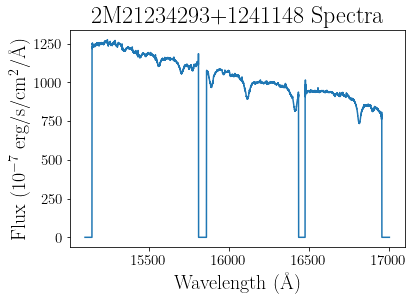

In [3]:
# Plot a single spectrum
CRVAL = f[1].header['CRVAL1']
CRDELT1 = f[1].header['CDELT1'] 
wavelength = 10**np.arange(CRVAL, CRVAL + len(spectrum)*CRDELT1, CRDELT1)
plt.xlabel("Wavelength (\AA)")
plt.ylabel("Flux ($10^{-7}$ erg/s/cm$^2$/\AA)")
plt.title('2M21234293+1241148 Spectra')
plt.plot(wavelength, spectrum)

In [5]:
# Download allstar DF
allstar = fits.open('./data/allstar.fits')
allstar_spectrum = allstar[1].data
allstar_error = allstar[2].data[0]
allstar_mask = allstar[3].data[0]

In [6]:
# Keep only giants by validating on params 
def validate_giant(star):
    return star['TEFF'] != None and star['SNR'] > 50 and star['LOGG'] < 4 and star['TEFF'] < 5700 and star['FE_H'] > -1 and star['SI_FE'] != None and star['MG_FE'] != None
giants = [star for star in allstar_spectrum if validate_giant(star)]  
print("before cut: %s, after cut: %s", len(allstar_spectrum), len(giants))


before cut: %s, after cut: %s 473307 254240


In [7]:
# Get filenames of all APSTAR files
import os
allfiles = []
fields = ['M15', '060+00', 'K2_C4_168-21', 'N6791']
filenames = [star['FILE'] for star in giants]
for field in fields:
    directory = './data/' + field
    for filename in os.listdir(directory):
        if 'DS_Store' in filename:
            continue
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            allfiles.append((filename, field))            

In [8]:
# Cross match giants along file anmes from APSTAR files
filtered = [giant for giant in giants if (giant['FILE'], giant['FIELD']) in allfiles]
filtered.pop(1622)
filtered.pop(1679)
len(filtered)

1852

In [9]:
#Download validated APSTAR files
apstars = []
for giant in filtered:
    fname = './data/' + giant['FIELD'] + '/' + giant['FILE']
    newstar = fits.open(fname)
    if len(apstars) == 0:
        apstars = newstar
    else:
        apstars = np.vstack([apstars, newstar])
len(apstars)

1852

In [10]:
# Pull out individual arrays
temps = [i['TEFF'] for i in filtered]
feh = [i['FE_H'] for i in filtered]
g = [i['LOGG'] for i in filtered]
logg = [i['LOGG'] for i in filtered]
mgfe = [i['MG_FE'] for i in filtered]
sife = [i['SI_FE'] for i in filtered]

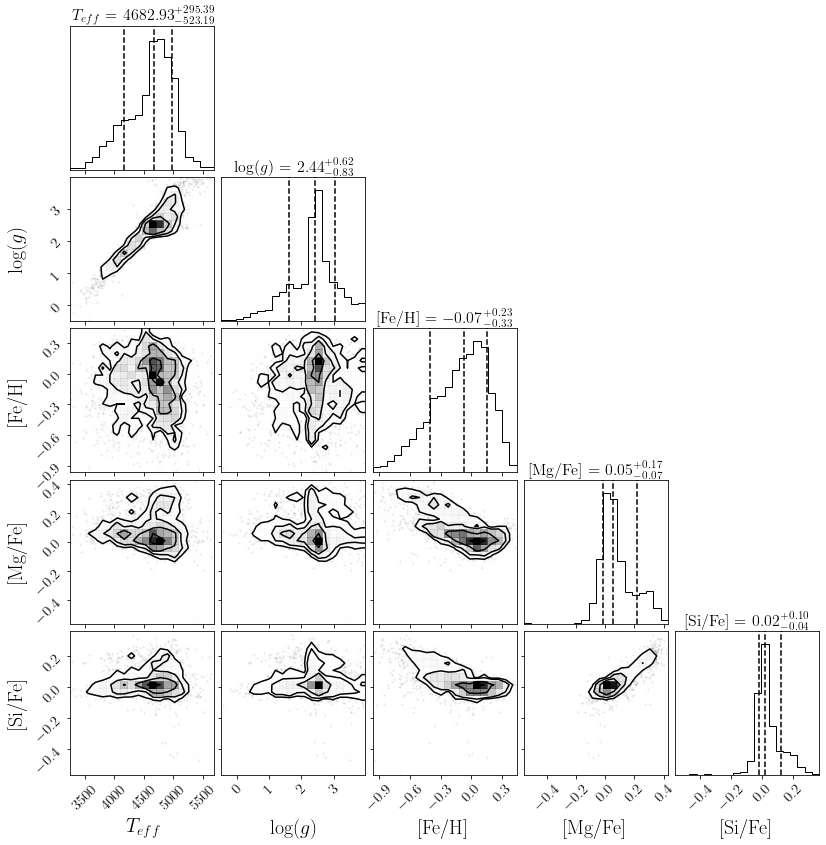

In [11]:
#Corner Plots for Labels
import corner
import arviz as az
samples = np.vstack((temps, logg, feh, mgfe, sife))

_ = corner.corner(samples.T, title_kwargs={"fontsize": 16}, show_titles = True, labels=[r"$T_{eff}$", r"log($g$)", r"[Fe/H]", r"[Mg/Fe]", r"[Si/Fe]"], quantiles=[.16, .50, .84])


In [12]:
npz = np.load('./data/cannon_continuum_apogee.npz')
filtered_waves = np.array(npz['wavelengths'][np.where(npz['trusted'])])

In [13]:
from astropy.nddata import bitmask
def validate_bitmasks(star):
    res = []
    for i in range(len(star)):
        arr = np.unpackbits(np.uint8(star[i]), count=13, bitorder='l')
        if any(arr[:8]) or arr[-1]:
            continue
        res.append(i)
    return res

526 7605 529


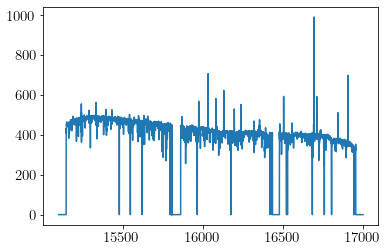

In [14]:
# Plot a single spectrum
f = fits.open('./data/N6791/apStar-r12-2M19205620+3752185.fits')
CRVAL = f[1].header['CRVAL1']
CRDELT1 = f[1].header['CDELT1'] 
wavelength = 10**np.arange(CRVAL, CRVAL + len(spectrum)*CRDELT1, CRDELT1)
wavelength = np.round(wavelength, decimals=6)
filtered_waves = np.round(filtered_waves, decimals=6)
bit_idxs = validate_bitmasks(f[3].data[0])
idxs = np.hstack([np.searchsorted(wavelength, filtered_waves)])
idxs.sort()
final = np.intersect1d(bit_idxs, idxs)
spectrum = f[1].data[0]
print(len(final), len(bit_idxs), len(idxs))
i = np.where(spectrum != 0)
plt.plot(wavelength, spectrum)
#plt.scatter(wavelength[idxs], [np.random.rand()*1200 for i in range(len(idxs))], s=1, c='r')

Text(0, 0.5, 'Flux ($10^{-7}$ erg/s/cm$^2$/\\AA)')

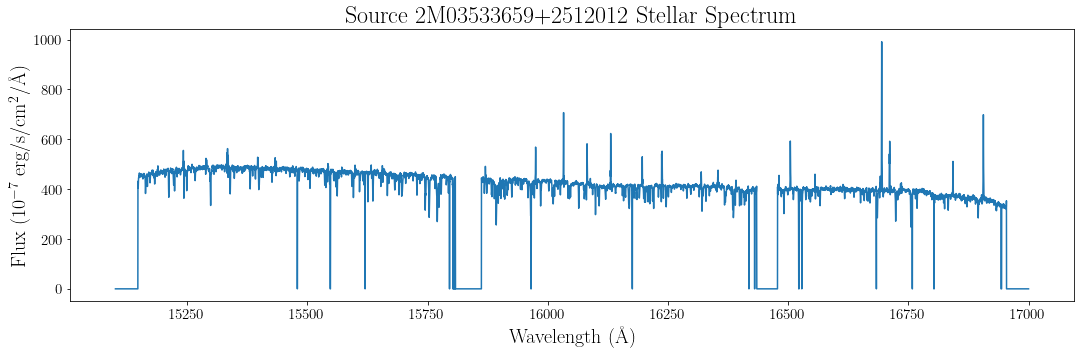

In [15]:
fig = plt.figure(figsize =(18, 5))
plt.plot(wavelength, spectrum)
plt.title("Source 2M03533659+2512012 Stellar Spectrum")
plt.xlabel("Wavelength (\AA)")
plt.ylabel("Flux ($10^{-7}$ erg/s/cm$^2$/\AA)")

Text(0.07, 0.5, 'Flux ($10^{-7}$ erg/s/cm$^2$/\\AA)')

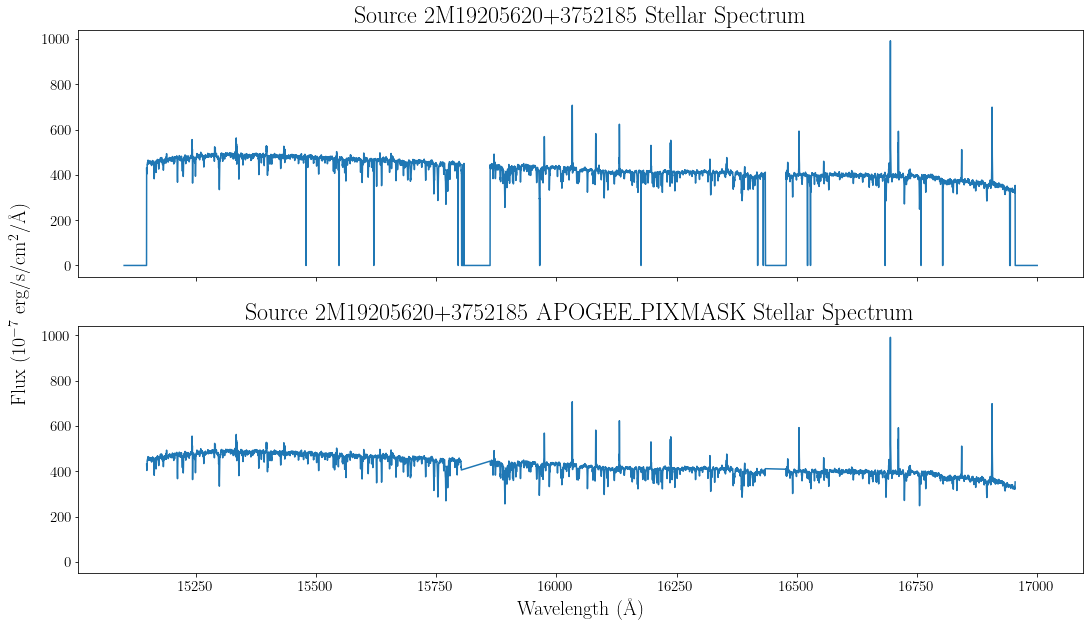

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(18, 10), gridspec_kw={'height_ratios': [1, 1]}, sharex=True, sharey=True)
axs[0].plot(wavelength, spectrum)
axs[0].set_title("Source 2M19205620+3752185 Stellar Spectrum")
axs[1].plot(wavelength[bit_idxs], spectrum[bit_idxs])
plt.xlabel("Wavelength (\AA)")
#plt.ylabel("Flux ($10^{-7}$ erg/s/cm$^2$/\AA)")
plt.title("Source 2M19205620+3752185 APOGEE_PIXMASK Stellar Spectrum")
fig.text(0.07, 0.5, 'Flux ($10^{-7}$ erg/s/cm$^2$/\AA)', va='center', rotation='vertical')

529


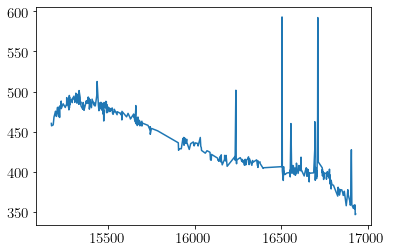

In [17]:
print(len(idxs))
plt.plot(wavelength[idxs], spectrum[idxs])

526


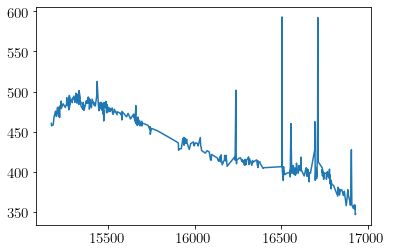

In [18]:
print(len(final))
plt.plot(wavelength[final], spectrum[final])

In [80]:
trusted_wavelength = wavelength[final]
trusted_spec = spectrum[final]
first = []
second = []
third = []
for i in range(len(trusted_wavelength)):
    wv = trusted_wavelength[i]
    if wv <= 15800 and wv >= 15150:
        first.append(i)
    elif wv <= 16430 and wv >= 15890:
        second.append(i)
    elif wv >= 16490 and wv <= 16950:
        third.append(i)
print(len(first), len(second), len(third))

def cut_sd(idxs, num, spec):
    curr = spec[idxs]
    m = np.mean(curr)
    std = np.std(curr)
    return [i for i in idxs if abs(spec[i]-m) < num*std]

first_cut = cut_sd(first,2.7, trusted_spec)
second_cut = cut_sd(second,2.7, trusted_spec)
third_cut = cut_sd(third,2.7, trusted_spec)

#first_cut = cut_sd(first_cut,2, trusted_spec)
#second_cut = cut_sd(second_cut,2, trusted_spec)
#third_cut = cut_sd(third_cut,2, trusted_spec)

print(sum([len(first), len(second), len(third)]) - sum([len(first_cut), len(second_cut), len(third_cut)]))
print(len(first_cut), len(second_cut), len(third_cut))
print(sum([len(first_cut), len(second_cut), len(third_cut)]))

241 107 178
11
238 106 171
515


In [110]:
def cut(trusted_wavelength, trusted_spec):
    first = []
    second = []
    third = []
    for i in range(len(trusted_wavelength)):
        wv = trusted_wavelength[i]
        if wv <= 15800 and wv >= 15150:
            first.append(i)
        elif wv <= 16430 and wv >= 15890:
            second.append(i)
        elif wv >= 16490 and wv <= 16950:
            third.append(i)
    return first, second, third

In [84]:
def split(trusted_wavelength, trusted_spec, sd=100):
    first, second, third = cut(trusted_wavelength, trusted_spec)
    
    first_cut = cut_sd(first,sd, trusted_spec)
    second_cut = cut_sd(second,sd, trusted_spec)
    third_cut = cut_sd(third,sd, trusted_spec)
    
    #print(sum([len(first_cut), len(second_cut), len(third_cut)]))
    return first, second, third, first_cut, second_cut, third_cut

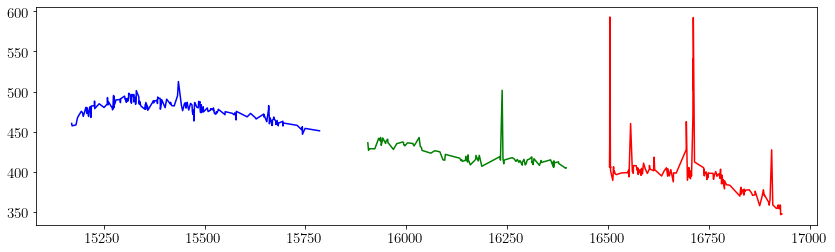

In [22]:
fig = plt.figure(figsize =(14, 4))
plt.plot(trusted_wavelength[first], trusted_spec[first], c='b')
plt.plot(trusted_wavelength[second], trusted_spec[second], c='g')
plt.plot(trusted_wavelength[third], trusted_spec[third], c='r')

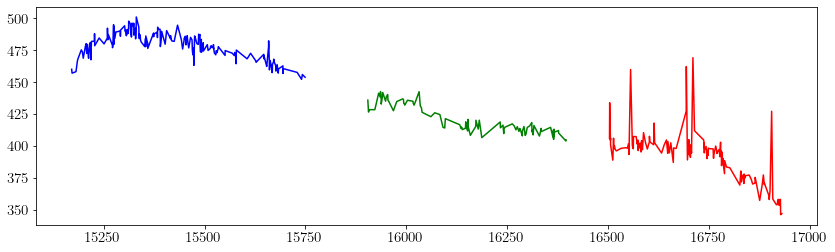

In [23]:
fig = plt.figure(figsize =(14, 4))
plt.plot(trusted_wavelength[first_cut], trusted_spec[first_cut], c='b')
plt.plot(trusted_wavelength[second_cut], trusted_spec[second_cut], c='g')
plt.plot(trusted_wavelength[third_cut], trusted_spec[third_cut], c='r')

Text(0, 0.5, 'Flux ($10^{-7}$ erg/s/cm$^2$/\\AA)')

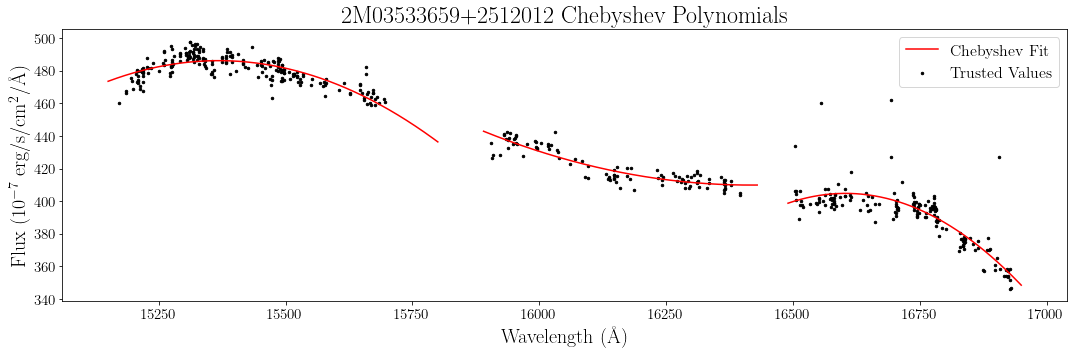

In [239]:
fig = plt.figure(figsize =(18, 5))
def fit(wv, spec, x):
    p = np.polynomial.Chebyshev.fit(wv, spec, 2)
    return p(x)

bit_waves = wavelength[bit_idxs]
bit_spec = spectrum[bit_idxs]
_, _, _, f, s, t = split(wavelength[bit_idxs], spectrum[bit_idxs], sd=3)
_, _, _, first_cut, second_cut, third_cut = split(trusted_wavelength, trusted_spec, sd=1.5)


vals1 = fit(trusted_wavelength[first_cut], trusted_spec[first_cut], bit_waves[f])
vals2 = fit(trusted_wavelength[second_cut], trusted_spec[second_cut], bit_waves[s])
vals3 = fit(trusted_wavelength[third_cut], trusted_spec[third_cut], bit_waves[t])
plt.plot(bit_waves[f], vals1, c='r', label="Chebyshev Fit")
plt.plot(bit_waves[s], vals2, c='r')
plt.plot(bit_waves[t], vals3, c='r')
plt.scatter(trusted_wavelength[first_cut], trusted_spec[first_cut], c='black', s=6, label="Trusted Values")
plt.scatter(trusted_wavelength[second_cut], trusted_spec[second_cut], c='black', s=6)
plt.scatter(trusted_wavelength[third_cut], trusted_spec[third_cut], c='black', s=6)
plt.legend(loc="upper right", prop={'size': 16})
plt.title('2M03533659+2512012 Chebyshev Polynomials')
plt.xlabel("Wavelength (\AA)")
plt.ylabel("Flux ($10^{-7}$ erg/s/cm$^2$/\AA)")

7605


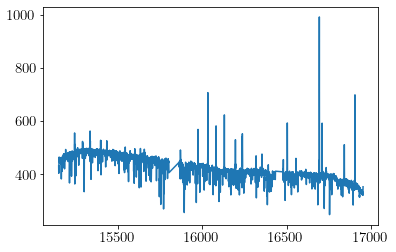

In [25]:
print(len(bit_idxs))
plt.plot(wavelength[bit_idxs], spectrum[bit_idxs])

7367


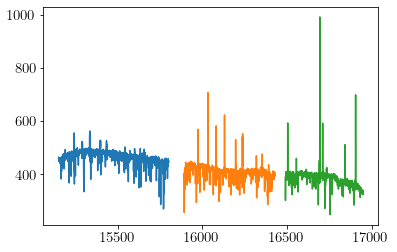

In [26]:
print(sum([len(f), len(s), len(t)]))
plt.plot(bit_waves[f], bit_spec[f])
plt.plot(bit_waves[s], bit_spec[s])
plt.plot(bit_waves[t], bit_spec[t])

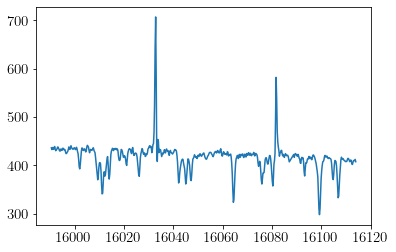

In [27]:
plt.plot(bit_waves[s][450:1000], bit_spec[s][450:1000])

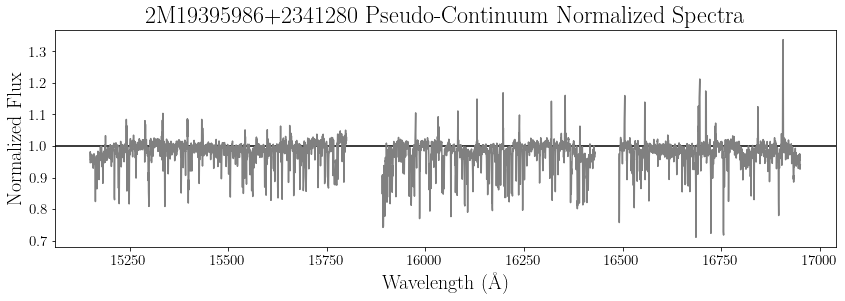

In [240]:
def normalize(obs, pred):
    return np.divide(obs, pred)

fig = plt.figure(figsize =(14, 4))
norm1 = normalize(bit_spec[f], vals1)
norm2 = normalize(bit_spec[s], vals2)
norm3 = normalize(bit_spec[t], vals3)
plt.axhline(y=1, color='black', linestyle='-')
plt.xlabel("Wavelength (\AA)")
plt.ylabel("Normalized Flux")
plt.title('2M19395986+2341280 Pseudo-Continuum Normalized Spectra')
plt.plot(bit_waves[f], norm1, c='gray')
plt.plot(bit_waves[s], norm2, c='gray')
plt.plot(bit_waves[t], norm3, c='gray')

In [259]:
def pseudo_normalize(filename, train=True, normal=True):
    npz = np.load('./data/cannon_continuum_apogee.npz')
    filtered_waves = np.array(npz['wavelengths'][np.where(npz['trusted'])])
    f = fits.open(filename)
    CRVAL = f[1].header['CRVAL1']
    CRDELT1 = f[1].header['CDELT1'] 
    if normal:
        spectrum = f[1].data[0]
        errors = f[3].data[0]
    else:
        spectrum = f[1].data
        errors = f[3].data
    
    wavelength = 10**np.arange(CRVAL, CRVAL + len(spectrum)*CRDELT1, CRDELT1)
    bit_idxs = validate_bitmasks(errors)
    
    bit_waves = wavelength[bit_idxs]
    bit_spec = spectrum[bit_idxs]
    if train:
        _, _, _, f, s, t = split(bit_waves, bit_spec, 3)
    else:
        f, s, t, _, _, _ = split(bit_waves, bit_spec)
    #plt.plot(bit_waves[3700:4200], bit_spec[3700:4200])
    #plt.plot(bit_waves[s][:500], bit_spec[s][:500])
    
    idxs = np.searchsorted(wavelength, filtered_waves)
    idxs.sort()
    final = np.intersect1d(bit_idxs, idxs)
    #print(len(final), len(bit_idxs), len(idxs))
    
    trusted_wavelength = wavelength[final]
    trusted_spec = spectrum[final]
    _, _, _, first_cut, second_cut, third_cut = split(trusted_wavelength, trusted_spec, sd=2)
    #print(len(first_cut), len(second_cut), len(third_cut))
    #print(sum([len(first_cut), len(second_cut), len(third_cut)]))
    
    vals1 = fit(trusted_wavelength[first_cut], trusted_spec[first_cut], bit_waves[f])
    norm1 = normalize(bit_spec[f], vals1)
   
    vals2 = fit(trusted_wavelength[second_cut], trusted_spec[second_cut], bit_waves[s])
    norm2 = normalize(bit_spec[s], vals2)
    
    vals3 = fit(trusted_wavelength[third_cut], trusted_spec[third_cut], bit_waves[t])
    norm3 = normalize(bit_spec[t], vals3)                                           
    
    final = np.hstack([f, s, t])
    idxs = np.searchsorted(wavelength, wavelength[bit_idxs][final])
     
    final_spec = np.array([-1. for i in range(len(wavelength))])
    bit_idxs = np.array(bit_idxs)
    final_spec[bit_idxs[f]] = norm1
    final_spec[bit_idxs[s]] = norm2
    final_spec[bit_idxs[t]] = norm3
    
    final_err = np.array([float("inf") for i in range(len(wavelength))])
    
    final_err[bit_idxs[f]] = normalize(errors[bit_idxs][f], vals1)
    final_err[bit_idxs[s]] = normalize(errors[bit_idxs][s], vals2)
    final_err[bit_idxs[t]] = normalize(errors[bit_idxs][t], vals3)
    
    
    weights = []
    for e in final_err:
        weights.append(min(100, 1/e))
    
    return final_spec, np.array(weights)
    
    
                                                 

/var/folders/sv/rwqdq4111xd02y21sdbzrp5h0000gn/T/ipykernel_1296/34416567.py:64: RuntimeWarning: divide by zero encountered in double_scalars
  weights.append(min(100, 1/e))


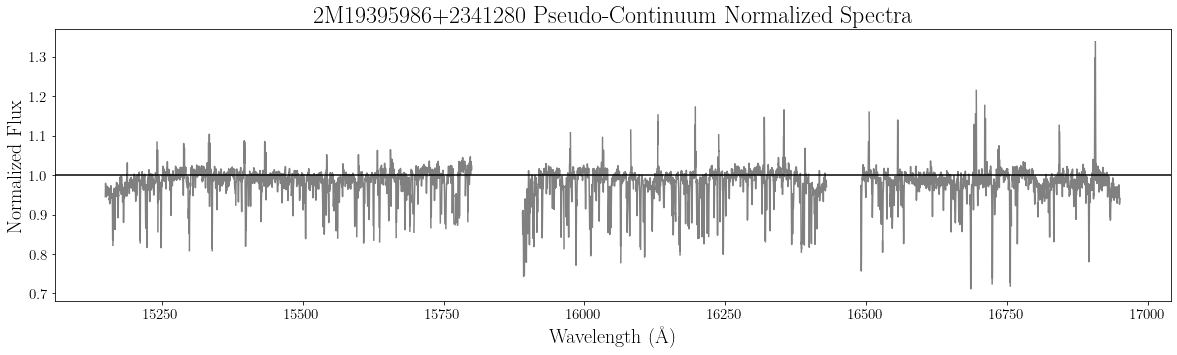

In [260]:
spec, w = pseudo_normalize('./data/N6791/apStar-r12-2M19205620+3752185.fits', True)
spec[np.where(spec == -1)] = np.nan
fig = plt.figure(figsize =(20, 5))
plt.xlabel("Wavelength (\AA)")
plt.ylabel("Normalized Flux")
plt.title('2M19395986+2341280 Pseudo-Continuum Normalized Spectra')
plt.plot(wavelength, spec, c='gray')
plt.axhline(y=1, color='black', linestyle='-')

/var/folders/sv/rwqdq4111xd02y21sdbzrp5h0000gn/T/ipykernel_1296/1945093534.py:64: RuntimeWarning: divide by zero encountered in double_scalars
  weights.append(min(10000000, 1/e))


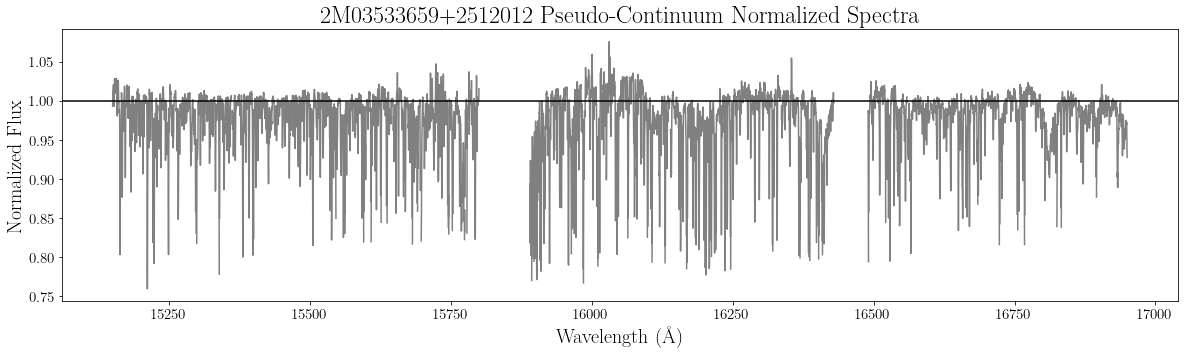

In [247]:
spec, w = pseudo_normalize('./data/K2_C4_168-21/apStar-r12-2M03533659+2512012.fits')
spec[np.where(spec == -1)] = np.nan
#spec[np.where(spec > 1.1)] = np.nan
#spec[np.where(spec < 0.4)] = np.nan
fig = plt.figure(figsize =(20, 5))
plt.xlabel("Wavelength (\AA)")
plt.ylabel("Normalized Flux")
plt.title('2M03533659+2512012 Pseudo-Continuum Normalized Spectra')
plt.plot(wavelength, spec, c='gray')
plt.axhline(y=1, color='black', linestyle='-')

/var/folders/sv/rwqdq4111xd02y21sdbzrp5h0000gn/T/ipykernel_1296/1945093534.py:64: RuntimeWarning: divide by zero encountered in double_scalars
  weights.append(min(10000000, 1/e))


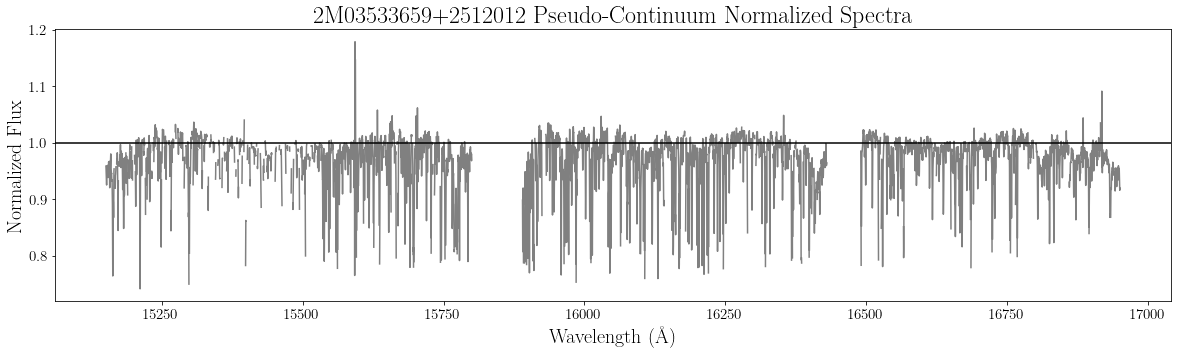

In [248]:
spec, w = pseudo_normalize('./data/M15/apStar-r12-2M21233366+1147521.fits')
spec[np.where(spec == -1)] = np.nan
fig = plt.figure(figsize =(20, 5))
plt.xlabel("Wavelength (\AA)")
plt.ylabel("Normalized Flux")
plt.title('2M03533659+2512012 Pseudo-Continuum Normalized Spectra')
plt.plot(wavelength, spec, c='gray')
plt.axhline(y=1, color='black', linestyle='-')

In [261]:
normalization = np.array([pseudo_normalize('./data/' + g['FIELD'] + '/' + g['FILE'], True) for g in filtered])
normalization.shape

/var/folders/sv/rwqdq4111xd02y21sdbzrp5h0000gn/T/ipykernel_1296/34416567.py:64: RuntimeWarning: divide by zero encountered in double_scalars
  weights.append(min(100, 1/e))


(1852, 2, 8575)

In [262]:
#60/40ish Cross-Validation Split
idxs = np.random.choice(range(len(apstars)), 952, replace=False)
others = [i for i in range(len(apstars)) if i not in idxs]
validation = apstars[others]
training = apstars[idxs]
weights = normalization[:, 1]
W = weights[idxs]
spectra = normalization[:, 0]
val_W = weights[others]

validation_spectra = spectra[others]
training_spectra = spectra[idxs]

validation_all = [filtered[i] for i in range(len(filtered)) if i in others]
training_all = [filtered[i] for i in range(len(filtered)) if i in idxs]

In [170]:
validation_spectra.shape

(900, 8575)

In [171]:
len(training_all), len(validation_all)

(952, 900)

In [251]:
def gen_terms():
    labels = ['TEFF', 'LOGG', 'FE_H', 'MG_FE', 'SI_FE']
    terms = []
    for label in labels:
        terms.append([label])
    for i in range(len(labels)):
        for j in range(i, len(labels)):
            terms.append([labels[i], labels[j]])
    return terms
print(gen_terms())

[['TEFF'], ['LOGG'], ['FE_H'], ['MG_FE'], ['SI_FE'], ['TEFF', 'TEFF'], ['TEFF', 'LOGG'], ['TEFF', 'FE_H'], ['TEFF', 'MG_FE'], ['TEFF', 'SI_FE'], ['LOGG', 'LOGG'], ['LOGG', 'FE_H'], ['LOGG', 'MG_FE'], ['LOGG', 'SI_FE'], ['FE_H', 'FE_H'], ['FE_H', 'MG_FE'], ['FE_H', 'SI_FE'], ['MG_FE', 'MG_FE'], ['MG_FE', 'SI_FE'], ['SI_FE', 'SI_FE']]


In [263]:
tmean = [[t['TEFF'], t['LOGG'], t['FE_H'], t['MG_FE'], t['SI_FE']] for t in training_all]
print(np.mean(tmean, axis=0))

[ 4.6013760e+03  2.3511467e+00 -1.1053240e-01  8.3424143e-02
  3.8264051e-02]


In [264]:
def build_a(star):
    terms = gen_terms()
    labels = ['TEFF', 'LOGG', 'FE_H', 'MG_FE', 'SI_FE']
    averages ={}
    for i in range(len(labels)):
        averages[labels[i]] = np.mean(tmean, axis=0)[i]
        
    a = []
    for term in terms:
        val = 1
        for label in term:
            val *= star[label]
            val /= averages[label]
        a.append(val)
    #tcub = star['TEFF']**3
    #a.append(tcub)
    #for label in averages:
    #    a.append(tsq*averages[label])
    a.append(1)
    return a

In [ ]:
def build_a_w_labels(labels):
    star = {'TEFF': labels[0], 'LOGG': labels[1], 'FE_H':labels[2], 'MG_FE':labels[3], 'SI_FE':labels[4]}
    return build_a(star)

In [265]:
def build_model(training_all, training_spec):
    
    A = build_a(training_all[0])
    for train in training_all[1:]:
        A = np.vstack([A, build_a(train)])
    return A, training_spectra.T

A, F = build_model(training_all, training_spectra) 

In [175]:
A.shape, F.shape, W.shape

((952, 21), (8575, 952), (952, 8575))

In [255]:
star = fits.open('./data/K2_C4_168-21/apStar-r12-2M03533659+2512012.fits')

allstar_star = [a for a in filtered if a['FILE'] == 'apStar-r12-2M03533659+2512012.fits']
speccer, w = pseudo_normalize('./data/K2_C4_168-21/apStar-r12-2M03533659+2512012.fits', False)
speccer[np.where(speccer == -1)] = np.nan

/var/folders/sv/rwqdq4111xd02y21sdbzrp5h0000gn/T/ipykernel_1296/1945093534.py:64: RuntimeWarning: divide by zero encountered in double_scalars
  weights.append(min(10000000, 1/e))


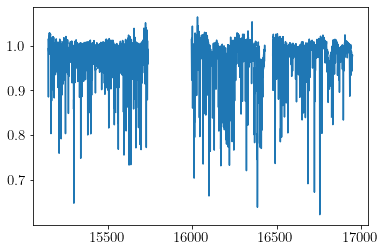

In [459]:
plt.plot(wavelength, speccer)

In [1057]:
len(training_all), len(training_spectra), len(validation_all)

(1102, 1102, 750)

In [272]:
def model(training_all, training_spectra, weights):
    #AX = F
    X = []
    A, F = build_model(training_all, training_spectra)
    for i in range(len(F)):
        w = weights[:, i]
        f = F[i, :]
        
        if len(f[np.where(f > -1)]) > 0:
            print(min(f[np.where(f > -1)]), max(f))

        w[np.where(f < 0.6)] = 0
        w[np.where(f > 1.14)] = 0
        w = np.sqrt(np.diag(w))

        Aw = np.dot(w,A)
        fw = np.dot(f,w)
        x, res, _, _ = np.linalg.lstsq(Aw, fw)
        if len(X) == 0:
            X = np.array(x)
        else:
            X = np.vstack([X, x])
        print(i)
    return X, A, F, W
X, A, F, W = model(training_all, training_spectra, W)

/var/folders/sv/rwqdq4111xd02y21sdbzrp5h0000gn/T/ipykernel_1296/2913631749.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x, res, _, _ = np.linalg.lstsq(Aw, fw)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
0.5403681678289121 1.1768957999653014
236
0.6717205408714548 1.0959969526209368
237
0.7805024606750753 1.1994220755873424
238
0.775898375178436 1.1224957541150788
239

474
0.7602881113671744 1.0204330956334122
475
0.7149777547077345 1.018138712792732
476
0.7151697459831815 1.0304737096883403
477
0.7515592308475826 1.1340542145460664
478
0.8075434484642109 1.0315682886669537
479
0.8630870198354206 1.0794653249445068
480
0.8959190646346102 1.060380614170787
481
0.8944751370847346 1.0988994248048627
482
0.8595930632653616 1.0501811153074487
483
0.8017462837988057 1.0352339707342766
484
0.7392167637122882 1.0159628203260813
485
0.6906681428219469 1.0324157212757623
486
0.666667190470167 1.058170782747535
487
0.6669062314152937 1.0140292983424488
488
0.6738776317578186 1.0244282068634938
489
0.6634104700754023 1.0212669773671883
490
0.6330169897580499 1.0265232467254164
491
0.6063031553465289 1.0172528456246799
492
0.6110098028978853 1.00546187897329
493
0.6666529668120099 1.0060835268615906
494
0.7681585968833003 1.0260867078281446
495
0.8778195310806 1.0433948239102322
496
0.9412008523503619 1.049826536663338
497
0.9240516350219469 1.0380719785340171
49

695
0.6159472462858655 1.0916018871078295
696
0.6630320861861106 1.0646832879295358
697
0.7174375625497362 1.1819155316202616
698
0.7574283939254732 1.197423746748921
699
0.7786923704543919 1.0706131810516992
700
0.7951229519413733 1.0884709839721627
701
0.816660158288378 1.0398063586845536
702
0.827201186341435 1.047755944622261
703
0.8086924496160226 1.158111845129259
704
0.7658563466555345 0.9982334996590183
705
0.7138031852020285 1.049542092915294
706
0.6772898297168612 1.034456470059363
707
0.6876328738804411 0.9555169250648995
708
0.7495932644738124 0.9652031071302574
709
0.8392295148301313 1.0495510484116592
710
0.8586649571459617 1.0359577597704248
711
0.8922803057633175 1.0906107839119372
712
0.9258410311361371 1.0755220944485722
713
0.9011633721443465 1.078306146251937
714
0.908496429380669 1.0178099652302381
715
0.8266926974705943 1.036218857597636
716
0.9521375914670557 1.0651893640427033
717
0.919123722516682 1.071349995996583
718
0.9406417144995812 1.0984168400445713
719


919
0.8870784091255044 1.0882111951362365
920
0.9049245799410429 1.0578432156705704
921
0.9073652141000529 1.0787147764488119
922
0.9090894314630766 1.0655135527827229
923
0.8905200940657717 1.0740347236802152
924
0.8847980952295705 1.0589392730972313
925
0.8690948401152894 1.0585924552642982
926
0.8321327847027217 1.0422816300648678
927
0.8079793120315728 1.0874367849056377
928
0.8242348540303925 1.0600315143386414
929
0.881044717980728 1.055741038426141
930
0.9375630010045828 1.0501591314749927
931
0.9290766957226412 1.0784213464400794
932
0.9071372518720919 1.0770983766479392
933
0.847455821980461 1.0768133364608516
934
0.7619473446870071 1.007876413733765
935
0.6956336656891835 1.0092604335969084
936
0.6445710949501235 1.042166126310778
937
0.6023526993598558 1.0580784187981926
938
0.5745163675862164 1.1061884847155135
939
0.553079228232974 0.9671456572645043
940
0.527025099948993 0.9134452166182285
941
0.5127126389549641 0.8610474049737166
942
0.5408363712464378 0.8682717551986694

1142
0.9011964049802835 1.0690065722898485
1143
0.8427873536754349 1.1253544948828442
1144
0.8448831751271693 1.050121442982229
1145
0.8811994275938927 1.0321444458779312
1146
0.8405996825982908 1.1364862547133945
1147
0.816730863562015 1.0170929524162813
1148
0.7744903747995722 1.030179331053889
1149
0.8788060121973748 1.0489090726596926
1150
0.9207492740262248 1.1196674607457058
1151
0.8407488623533705 1.0554716256256298
1152
0.9534456335677631 1.0945881184171213
1153
0.9008241888373156 1.1236655710655412
1154
0.9541518795558966 1.0966733734342151
1155
0.8467372303958702 1.0470724545560584
1156
0.924216385099808 1.0296974574812934
1157
0.8704234585823643 1.07553572743023
1158
0.9083221849722543 1.0235714134223306
1159
0.8402989123462425 1.1158967050859847
1160
0.8353127708271162 1.0353938433721317
1161
0.8513621639019953 1.0157524461886636
1162
0.8422686090182193 1.114169759640684
1163
0.6879109309601612 1.0593130922062564
1164
0.7152209387513256 1.0140175082902474
1165
0.78228872182

0.7066428668437832 1.0249599790780415
1368
0.7581538256170733 1.0448526734851782
1369
0.8312073423353473 1.036817581085355
1370
0.8983314326045145 1.0667460639262811
1371
0.9384977083161392 1.057973036652575
1372
0.9603643006822034 1.0524610901250593
1373
0.9550200816451179 1.0986385724950334
1374
0.9569625908095539 1.078652801875313
1375
0.904631611595768 1.0680561274642066
1376
0.8401875605529854 1.0464336114039556
1377
0.7537289729822038 1.0703772825874365
1378
0.6528760437945113 1.0689048444830873
1379
0.5738047329663309 0.9958576310245925
1380
0.5347485711694745 0.9870484279894803
1381
0.5282835264525908 1.0800099731272685
1382
0.5460756549371264 1.1134872812261052
1383
0.5796294322726838 1.1967461747263046
1384
0.6331019379650051 1.1659917728575804
1385
0.7175125743915303 1.281364170622593
1386
0.7309402089598673 1.57265399610278
1387
0.8166951341247829 1.1177917587990542
1388
0.9096353720099715 1.152056428829175
1389
0.8783639655876202 1.7779191524067883
1390
0.7408032272128104 

1591
0.730379606299063 1.173840052083336
1592
0.7872288454720366 1.4675909826061126
1593
0.7386396767174525 1.1447598802853924
1594
0.6815381165187943 1.1534427132544536
1595
0.7288816846631906 1.1878088665736157
1596
0.7559840190671434 1.1322539786441068
1597
0.7341829280093175 1.1212115184903162
1598
0.703537489875545 1.1299442996260756
1599
0.6900476844514684 1.1065718790495362
1600
0.6330624209992041 1.133095857890595
1601
0.626337025111228 1.04253922708209
1602
0.6418123885622432 1.1019429955481679
1603
0.6872315338952043 1.1355835534249266
1604
0.7594679983784131 1.0895008039251153
1605
0.7965018217102859 1.0934679902509234
1606
0.8078372157462628 1.0406466210228544
1607
0.8175761781660653 1.0328072494408
1608
0.7973992642347983 1.1014811932475224
1609
0.7482222185679519 1.1645820983950959
1610
0.7020962140050401 1.0464259664634268
1611
0.6905665666905715 1.0758322105708966
1612
0.7109962303740357 1.0238893938225155
1613
0.7413528184964691 1.0433962924177171
1614
0.77284336504675

1811
0.831998709333673 1.0167962540281252
1812
0.8688280860538536 1.0213608933723224
1813
0.8896271070240517 1.01633332142777
1814
0.9086052686190295 1.028083573485069
1815
0.9020914929148428 1.0321002924673246
1816
0.9148112699560866 1.0453218682226668
1817
0.9400948367071299 1.0383252263861888
1818
0.9474163606969543 1.0364375637122216
1819
0.9412614885710067 1.0355246229446573
1820
0.89349148956268 1.035684360204924
1821
0.8310980431812811 1.0323077268688334
1822
0.7804388444077773 1.0285758598266233
1823
0.7737361443008817 1.0443186387555476
1824
0.8236093267249489 1.0318630039205396
1825
0.9059700236388982 1.0401665179450974
1826
0.9658295588426661 1.0808811370311209
1827
0.9637751145844179 1.0625648929506464
1828
0.9596361299408772 1.0686148450654374
1829
0.9485052371055338 1.0830811130329518
1830
0.9429964143523956 1.0895763404377872
1831
0.9483636414762584 1.0900134650279878
1832
0.9138164082621899 1.0890986634163102
1833
0.961012620518971 1.0896683538723066
1834
0.958300659825

0.9255453679785126 1.0197374282260148
2036
0.9294829691851774 1.0352791410841435
2037
0.9198299409273198 1.031047012940526
2038
0.8638790323522557 1.0859249773450257
2039
0.8417483961077342 1.1562412137823224
2040
0.8656705203093835 1.0562585652379524
2041
0.9231489422557674 1.0428728667503049
2042
0.9359517419493885 1.05385165757898
2043
0.9361111215514811 1.0936859349685994
2044
0.9413556283847678 1.0749495802164433
2045
0.9492817645391277 1.0985326710697656
2046
0.9469483536182441 1.1352509944515305
2047
0.9340587854840683 1.0684334271315061
2048
0.9146269452138651 1.0770849351369591
2049
0.8480383526860995 1.0800740227524075
2050
0.778249269082487 1.0997948535018849
2051
0.7373181677523026 1.0641098460561027
2052
0.7389651836358795 1.113201878934176
2053
0.7630056096178335 1.0263878878039112
2054
0.7844742916718516 0.9945986917963896
2055
0.7602643134517588 1.031141363393181
2056
0.7398799738653088 1.0488048628050528
2057
0.7541562129175111 1.0111941630947767
2058
0.703688299889836

2243
0.47545761020993954 1.0156958831649432
2244
0.5160601720954939 1.042712639617358
2245
0.6238287574858503 1.0541050787143167
2246
0.7585930341459998 1.0356995927990058
2247
0.8506537924172156 1.0338955427301633
2248
0.8599895017041064 1.029357378278114
2249
0.8783956652162692 1.0533816308191422
2250
0.9241910904293827 1.0405905087676093
2251
0.9303282295180277 1.112657566078861
2252
0.9403905454548329 1.135197895399421
2253
0.9507455421959091 1.0490785870511445
2254
0.9604681387640801 1.0495717353319551
2255
0.9378793295588226 1.0370958785940376
2256
0.8795646435166085 1.0522702896003573
2257
0.8318960109823548 1.0456094123831268
2258
0.7923378008164382 1.0488501223600026
2259
0.7615432397045894 1.0482827874256442
2260
0.7323813001975844 1.027447638241977
2261
0.7018793315921014 1.0549841505902158
2262
0.6888245714157591 1.025425402802284
2263
0.6249212573845964 1.0297607643186752
2264
0.7388627707122029 1.0355679817603465
2265
0.7729942323830835 1.0344357650474367
2266
0.767107627

2453
0.6985371130278246 1.0334373677951492
2454
0.7365919612074706 1.0331297043594514
2455
0.8103386094298114 1.045231423540727
2456
0.9034031458193055 1.0432067473948283
2457
0.9622205531985399 1.0742143478363841
2458
0.9779516472282845 1.133875445143697
2459
0.9747648605779512 1.130643178189148
2460
0.9750196276553498 1.1296776874864412
2461
0.9586743736887628 1.1153514511017222
2462
0.9614684647906442 1.086513068806127
2463
0.9706561592701786 1.0539768980772388
2464
0.9085809468694291 1.0447857161316043
2465
0.8404046763038763 1.0316601202094349
2466
0.8259120500848954 1.0252566982174494
2467
0.8660741603215932 1.0272191630381085
2468
0.9071273351283968 1.0226352875455673
2469
0.886862844671159 1.0113425279310027
2470
0.8526232462627455 0.9919832093388725
2471
0.7678598130179131 0.9550026235228997
2472
0.6829098590002686 0.9013986474663835
2473
0.6209455026598457 0.9052747581427173
2474
0.6455822577375219 0.9133435731121072
2475
0.6621305473021655 0.9459181382526504
2476
0.689999474

2678
0.8406672010530339 1.1014786339480422
2679
0.8557809224858143 1.0328861726014669
2680
0.8848063290668252 1.0531322084450787
2681
0.9245543860930775 1.0490183240108966
2682
0.9554434474961175 1.0619281948298342
2683
0.947468108164834 1.0504843781009474
2684
0.9257292002214905 1.0566994109793981
2685
0.911141929136037 1.047610437594106
2686
0.9022252874672922 1.0444161500604505
2687
0.9319625749545496 1.0504150568214279
2688
0.9329969261912024 1.0474912296362615
2689
0.8870659925731366 1.0410270219626823
2690
0.8451604394581321 1.0297928147504865
2691
0.7936734988698546 1.044054996300405
2692
0.7677424358866041 1.0330792529582065
2693
0.7980822881506473 1.0683140539563067
2694
0.8619490475450979 1.045481842982211
2695
0.921531437705159 1.128002202071076
2696
0.9201064434659263 1.0155628624054402
2697
0.8894147392621714 1.009701161518183
2698
0.9043119879683496 1.0111047304558478
2699
0.900206306643696 1.108442698503984
2700
0.8083359630188225 1.009430240312178
2701
0.869408412899552

2895
0.9645227380899576 1.182777350734775
2896
0.968973859375747 1.1605293612313334
2897
0.9597308415341158 1.1479037448996525
2898
0.9576235016207708 1.124444710243272
2899
0.9532007716928671 1.1441995746114062
2900
0.9324628588265292 1.0969042261697657
2901
0.9021337673016168 1.0896129085512083
2902
0.8687291664221749 1.0665213228616874
2903
0.8038853052986258 1.06520392452565
2904
0.7178910470801702 1.1104896216234115
2905
0.6420797606326281 1.0790622162563974
2906
0.5555674675656361 1.0122968167568327
2907
0.49945805857700026 1.0398460756934897
2908
0.5624057818701594 1.063503195704934
2909
0.6988581002317968 1.044211626324303
2910
0.8087925095957638 1.0643743813717508
2911
0.8449933722021117 1.0853959478495026
2912
0.7794017547111314 1.1535658680386076
2913
0.6363773410280447 1.122869854187023
2914
0.5307382975971301 1.0480738286347706
2915
0.5427222108060247 1.0291583815472722
2916
0.6645567180928605 1.7243000345251263
2917
0.8298646489111797 1.1306664582231734
2918
0.95935751528

0.8769470523373218 1.0975665258557528
3114
0.8942756437696031 1.0826151370386519
3115
0.8616045814318501 1.0910417859436141
3116
0.8011327469154218 1.0946998611769736
3117
0.7227527303892323 1.0713770110468972
3118
0.760492547455262 1.0308908015745464
3119
0.8109993986419342 1.0269816348615892
3120
0.835928929244293 1.0791733431066157
3121
0.8372449121281784 1.1612783728952265
3122
0.779192644662043 1.1000562275984744
3123
0.850287953007445 1.0717987946239096
3124
0.8167139963977545 1.4080049779867179
3125
0.845988154983221 1.322169056775657
3126
0.8285473570233398 1.3487418247958007
3127
0.7468933921102401 1.095543300435418
3128
0.8082505300349401 1.0594510826325059
3129
0.7952463504756687 1.0349812398600913
3130
0.7864656846555308 0.9970510182973589
3131
0.7359780276012139 0.9767438650954271
3132
0.6910381367324998 0.9550505542406937
3133
0.7181900380225011 0.9596861209626167
3134
0.6922659545588639 0.9719963579462462
3135
0.6573970462672332 0.9632701816141607
3136
0.6395975591806811

3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
0.7923506141096809 0.9459173010517212
3688
0.7225000200497865 0.9299211955850949
3689
0.6993459496993629 0.9110259444192333
3690
0.7406078743238873 0.9625756391056438
3691
0.799284190239837 0.9568307809060068
3692
0.8140299320474134 0.9806910238966885
3693
0.7936185805162185 0.9693808622428315
3694
0.7451185079960068 0.9256677020411641
3695
0.5850656150763132 0.8830095077653899
3696
0.45794338983089533 0.8338520384400858
3697
0.4122988821166731 0.7552636619381037
3698
0.4237178921221495 0.7103561796938739
3699
0.436135423488

3891
0.9353606045378934 1.0761034171201602
3892
0.914146046132936 1.0748850269141568
3893
0.8625640310590872 1.0526933158758727
3894
0.839667363596924 1.0395353895988249
3895
0.8579595097325436 1.0453010680606314
3896
0.9019815928916903 1.050666955611214
3897
0.9024477311682773 1.0778155686432593
3898
0.9086185558056646 1.092166724572126
3899
0.9615101218706044 1.086146191838418
3900
0.9261141488079572 1.1128562946766833
3901
0.9449105988188086 1.1022814297672971
3902
0.9831624984219878 1.0830834073750009
3903
0.9599101428465956 1.0783103762523572
3904
0.9417908530230407 1.079513989287768
3905
0.8995759704631714 1.051687797637581
3906
0.8497901992873744 1.0402892437188094
3907
0.8801110672788798 1.0547081098957312
3908
0.9303334482762696 1.0652770247430954
3909
0.9722162300319241 1.0682982554292169
3910
0.9823460183472578 1.0948136693773358
3911
0.9838624794479276 1.118653714328678
3912
0.9881297955141685 1.125528303086027
3913
0.9817760751915583 1.1328636223500559
3914
0.9355182998506

0.5312068016361333 1.0399516771697486
4104
0.4775804366594914 1.0431555768506093
4105
0.4592736958527309 1.0375796272550786
4106
0.46489595206865847 1.0355458983497998
4107
0.4930011128607469 1.0314803566025408
4108
0.543522558133192 1.0307689773501787
4109
0.5857585962437295 1.0679209701585872
4110
0.5888628544940547 1.030094459398042
4111
0.5741664340924428 1.0270275644687075
4112
0.5807929785934447 1.0259865624065456
4113
0.6073987985445692 1.0386164705690155
4114
0.6128406118016909 1.028342981730208
4115
0.5785598484849427 1.0017806380755754
4116
0.5328445726283925 0.964344434771805
4117
0.5178611935019668 0.918432241670296
4118
0.5601936540683253 0.9186017882920027
4119
0.6402226803604801 0.9167112630855192
4120
0.6712263035980239 0.9428645749632453
4121
0.6483363557304511 0.9867816154883756
4122
0.5889666926267108 0.9968207509034074
4123
0.5491263209322967 0.9932144726112909
4124
0.5903167819746657 0.9899837432840737
4125
0.6568376706738193 1.0221861385992688
4126
0.7074418970489

4315
0.7597310783171293 1.188128484979448
4316
0.7009566236586264 1.2547778522802384
4317
0.7922722193292191 1.3725191522441298
4318
0.4155660886315622 1.2232938562349251
4319
0.42074084175553883 1.2092379628870946
4320
0.6212679524822177 1.2489081819560894
4321
0.6422244466438387 1.3675742930997938
4322
0.5701622836484433 1.3337966634121523
4323
0.5410509291410055 1.3749146901638105
4324
0.5503167068003495 1.3129748801193775
4325
0.5628690742381937 1.2598200927284888
4326
0.6008934245686772 1.253917910150435
4327
0.6667080175083782 1.3166995989371764
4328
0.7639990474865184 1.325805994895781
4329
0.41389175520221816 1.2975280272924266
4330
0.3261397498403437 1.5297428251093068
4331
0.747477260390826 1.5281757323210028
4332
0.7065636370703167 1.3763598489916509
4333
0.707595622679679 1.3622445319599226
4334
0.7618113843870333 1.2256912258101158
4335
0.6848772879192555 1.3312892738173425
4336
0.41950435278365994 1.2859654287893347
4337
0.5288392455487996 1.293983640897893
4338
0.7620518

4530
0.7879173067966272 1.0911905644009587
4531
0.755647676520566 1.1572712466481212
4532
0.8061685773158871 1.3170084360767522
4533
0.6787878261057284 1.1209604814927234
4534
0.80151482832601 1.1240911281012256
4535
0.8877648937082505 1.183393743071527
4536
0.7860393199422373 1.1252101160779124
4537
0.8058326355345826 1.2059541738648287
4538
0.7525126959701857 1.1425621655869675
4539
0.6105178382001556 1.134234086641906
4540
0.537742622333265 1.234822585180052
4541
0.5810982603691723 1.3001431751906698
4542
0.5998015565478751 1.1989573436602317
4543
0.6599547525952167 1.1863545642901063
4544
0.6406685345404718 1.307510423816833
4545
0.6695145736957178 1.448402972882156
4546
0.6341104906803452 1.4192781956884493
4547
0.671256964321783 1.2682046559369895
4548
0.5957392530374317 1.328160712757672
4549
0.6882244922372441 1.3226736018319232
4550
0.5393417739844407 1.212027330005449
4551
0.4939414772496999 1.3088966959560497
4552
0.7414011110111766 1.4897206971383625
4553
0.7859621361534926

4752
0.7768741685284246 1.2062237403618294
4753
0.7307522049014638 1.1872568988813539
4754
0.7327332736976009 1.288247622107633
4755
0.7402109040260508 1.2224302566141934
4756
0.7483247219503573 1.2757374059812558
4757
0.6876118898978174 1.1861479424596801
4758
0.5953540663952271 1.18055862070583
4759
0.5943809725097209 1.2265594245622968
4760
0.6214868098800521 1.3153525683291516
4761
0.621179381286874 1.25960627875701
4762
0.716340741041224 1.2162843304026176
4763
0.6757266737397233 1.500381813432309
4764
0.6328875173958994 1.2369869382663057
4765
0.6236612141904053 1.3481995340691495
4766
0.5623621327306438 1.5157238464066274
4767
0.6581035297851341 1.23469822534423
4768
0.7151790209582977 1.3482691930604471
4769
0.315153679238778 1.2297735529631713
4770
0.5216757752517134 1.270579606041194
4771
0.6171769416820745 1.2137210936401976
4772
0.638996216451396 1.209538978238133
4773
0.5338323413173873 1.2036798177093302
4774
0.6377814645805409 1.2909319135096287
4775
0.6576971947603282 1

4961
0.9636615303846506 1.1392434872429673
4962
0.9318353063181118 1.0874343886293343
4963
0.8561403320150753 1.0190601782531603
4964
0.7664206132345783 1.0203489432737274
4965
0.756972159540848 1.0429324827541693
4966
0.8372812235620891 1.0234445731735875
4967
0.9019491799174852 1.0320093372571955
4968
0.9562264233264531 1.0646332177141122
4969
0.9438091720959234 1.1139434051623787
4970
0.9059978888775253 1.1276047308575972
4971
0.8965303260965296 1.1241250909687672
4972
0.8989723145712196 1.1407716489934014
4973
0.9222806866065257 1.166256629613781
4974
0.9630496401707231 1.1705507048875234
4975
0.9601732904132032 1.1570536589353917
4976
0.9518603496096567 1.1342647110208994
4977
0.9437314155415097 1.104920471953012
4978
0.9170416541976496 1.0737011902166507
4979
0.8897129823955611 1.0598894722563148
4980
0.9121694469799345 1.0747739833566623
4981
0.9471159495902696 1.0910531342709893
4982
0.9612376533898178 1.0914153973399496
4983
0.9491751690677207 1.102971126124186
4984
0.95814953

0.7887479122380749 0.9256877066994772
5174
0.7059557488244675 0.9076912592493085
5175
0.6544973558882683 0.9013358629211679
5176
0.6708051685351489 0.8991054221898965
5177
0.6713132191321629 0.9535138230607181
5178
0.6641195355708414 1.0008382257490198
5179
0.6764015702651476 1.029758531943324
5180
0.7218864387935546 1.0542523103695574
5181
0.7970927822482867 1.0650066563752547
5182
0.8740003908928353 1.046072996498888
5183
0.884885230618005 1.0371939648942445
5184
0.8344421319055252 1.0840105550093058
5185
0.750610751021308 1.094432033884768
5186
0.7128455213183287 1.0418133455574332
5187
0.7453482928536789 1.0525718624769844
5188
0.7958417486647048 1.059551736679628
5189
0.8390310304163304 1.0487609481121438
5190
0.8618113820696095 1.0868109965058528
5191
0.7420972807837736 1.0567898959356876
5192
0.8109133465682397 1.0807275449961469
5193
0.7176127478231533 1.0545159965176067
5194
0.6210980925107993 1.0538130324801889
5195
0.5967484506291733 1.0417830761864442
5196
0.666444919069527

5395
0.842605907027762 1.0652452814738884
5396
0.794421979052277 1.0831751793416897
5397
0.7402426387948167 1.0803945962185029
5398
0.7072677586681664 1.0948470279426386
5399
0.7148328927870411 1.0711238600866615
5400
0.7454030250530735 1.0647985401220406
5401
0.7785459974550605 1.085611712539657
5402
0.8164916804985658 1.072919146835847
5403
0.8898830886367901 1.055746048939106
5404
0.9464725588362726 1.0798765637853602
5405
0.9530581704293484 1.1422118224871864
5406
0.9590732672250748 1.1587463299489151
5407
0.9733379175023806 1.160951660324449
5408
0.90098399324989 1.1464138308507938
5409
0.9620940854988009 1.1270433049688526
5410
0.9581355031895026 1.083185929807621
5411
0.9234048345842405 1.0832560919508918
5412
0.8016144780934841 1.1064006823534913
5413
0.6583740362130288 1.1034602516172878
5414
0.6468333684542834 1.0464533576289765
5415
0.7395581860741648 1.0830717829845786
5416
0.8815851142082365 1.0979731774581851
5417
0.9714272015510562 1.0824330990052415
5418
0.9696961214285

5611
0.9050634647090529 1.2965462325209625
5612
0.9335297816229196 1.323133676279914
5613
0.8913985689555342 1.6028331957768513
5614
0.8790936784179291 1.7316788494193793
5615
0.8281406830295045 1.556581052315517
5616
0.9150386962647901 1.3428211287757035
5617
0.8835936959921901 1.1533603089971118
5618
0.8918367809540821 1.1992562836333138
5619
0.8370989193482801 1.0923899821609857
5620
0.7966012393750721 1.1398147818133426
5621
0.6994958508690815 1.2469028359330065
5622
0.6092966238393261 0.9789870124102278
5623
0.5871963131918361 1.233360361645015
5624
0.6324394767600194 0.9700114681152775
5625
0.6756718371723113 1.0446239326672622
5626
0.7122640145984876 1.3120696901574123
5627
0.7366047888453734 1.1495196491673385
5628
0.7596356775733374 1.1608872474665213
5629
0.7880911087342687 1.2882093427091992
5630
0.8145030985689512 1.2350505655345714
5631
0.8280592260492383 1.1191111857944662
5632
0.802485619805322 1.0608677755187947
5633
0.7727143610128957 0.9900165725917662
5634
0.83062982

5811
0.9305020448647224 1.0774524928898024
5812
0.9459538581451158 1.1489100820756508
5813
0.8775297666379868 1.1620726358244524
5814
0.9097453155051883 1.1491716335236914
5815
0.9540663188816818 1.0809704157797357
5816
0.9533433458652452 1.0909034724675277
5817
0.9500057942370808 1.1863382642244646
5818
0.9392192518914807 1.074379563275801
5819
0.9623035970476069 1.073580858101578
5820
0.9404563184187327 1.1936314841518272
5821
0.9292667725046118 1.119289483839
5822
0.949712433612319 1.1617291902659501
5823
0.8590118167519273 1.1251802235631472
5824
0.9339527686549963 1.052173239824337
5825
0.9348781121994328 1.1872587346850927
5826
0.9139345252922865 1.0542363796437781
5827
0.8634129198979514 1.0448746144766736
5828
0.7482802692138047 0.9935329148902695
5829
0.6670673656268704 0.9284947403588234
5830
0.6856488564913593 0.9431747857207886
5831
0.777948457475347 0.9616883398041948
5832
0.8233005329455404 0.9874893196061914
5833
0.8325160407693698 1.012906903180777
5834
0.80870386117730

6008
0.6138829931069422 1.1333191344264868
6009
0.6383312646478954 1.0876433542721615
6010
0.6857635197882744 1.1829577823573596
6011
0.6812632951070976 1.1881538690301707
6012
0.6599437216460818 1.0957048187886254
6013
0.6195842950964587 1.0017867645454603
6014
0.5900265418848121 1.0271919453509042
6015
0.5848490049659085 0.9617610029439735
6016
0.586824349536945 1.0319531496576033
6017
0.5969452299863722 1.0367182618494886
6018
0.5782721464283888 0.9807571390579353
6019
0.534095443520385 0.9743442380255263
6020
0.5844547928287339 0.9792618959893667
6021
0.6982707473664015 1.0131609934937396
6022
0.7904992909259255 1.0339354733350603
6023
0.8157905262812846 0.9959436176801902
6024
0.8026756310304601 1.0479873038264043
6025
0.7739603911802996 1.0685041331516336
6026
0.7003213805130015 1.1375310135513612
6027
0.6580948092297924 0.9702343415235772
6028
0.5957191942840449 1.1879804664096938
6029
0.5883695016613091 1.1843055649927583
6030
0.6695009623979814 1.0443357530896742
6031
0.766864

6462
0.8186774489956679 1.0579494481244311
6463
0.900304058543378 1.097177781234274
6464
0.949111710516444 1.0879199186256823
6465
0.9482514854491152 1.109048849602894
6466
0.9501397664448149 1.1007989608205142
6467
0.9401382450414072 1.0968779402739324
6468
0.9065331781937513 1.1121495316928027
6469
0.9357019289903278 1.1277625817580772
6470
0.9384146912324943 1.1365618715421875
6471
0.9122845315896007 1.1796201915428415
6472
0.9099933615073096 1.1070855639344293
6473
0.9510530819361559 1.0605444995409552
6474
0.9403428515101211 1.0459095760369443
6475
0.9205598528538252 1.0651578851248533
6476
0.9407860730070579 1.0914551687343876
6477
0.9714120047008078 1.126874932457576
6478
0.9673095539256718 1.1481774996626621
6479
0.9695436434932636 1.1478186184315256
6480
0.9643839414969405 1.1203218595425521
6481
0.9219127583156583 1.0753251028827902
6482
0.907912989694542 1.0497218296226458
6483
0.8565320728854182 1.0378605465514137
6484
0.8277192115215335 1.1131234927320484
6485
0.8561131152

6670
0.9603062552833556 1.1637767392799063
6671
0.9629813497361596 1.1230083026651458
6672
0.9398244688540439 1.1512776908455837
6673
0.8771571485814268 1.248594176908587
6674
0.8727010982482383 1.2178316277458763
6675
0.938489605897446 1.3347086025004877
6676
0.8059265194860488 1.088342422549786
6677
0.873968440465022 1.1145060379504814
6678
0.8002688676427756 1.0088056727727175
6679
0.7746003374600808 1.0503727800453726
6680
0.8091788645619571 1.0365618633042135
6681
0.8241061099930574 1.021638915217686
6682
0.8193865231115677 1.067757351954699
6683
0.8198180203971855 1.0710341510209078
6684
0.8400100348580388 1.072200650999597
6685
0.886090843286694 1.0855580420159898
6686
0.9122975242459224 1.1341744644098626
6687
0.9256248765027641 1.0796892956632083
6688
0.8793044182785342 1.0470009192094565
6689
0.7466212995860952 1.0982016370457348
6690
0.883298949149654 1.0444253732003905
6691
0.8115559650836539 1.0327642274566886
6692
0.7516196464144314 1.036707700929363
6693
0.73496926665659

6879
0.9303142475395962 1.0981781974697267
6880
0.9504110372964345 1.1282880709456733
6881
0.9362976379425034 1.130668160306036
6882
0.9573823690766885 1.1248072632296255
6883
0.9583985977312073 1.121032962120229
6884
0.9627244841021528 1.121143965174323
6885
0.953403180007016 1.1208724246817832
6886
0.9205042569097266 1.0873891872303652
6887
0.8901647422392744 1.092520475795468
6888
0.9128128033342866 1.098720888631121
6889
0.8495784291504556 1.0862605311460634
6890
0.8097203828033992 1.1361335880576382
6891
0.7723381102855589 1.1328928560739935
6892
0.6985873344324137 1.1461983610953652
6893
0.6199141346095817 1.1003701854850088
6894
0.6134162496224707 1.1239769047460917
6895
0.6996310528555457 1.129958202615261
6896
0.8045290629677191 1.1401121924136366
6897
0.8210548465629508 1.1450921915592762
6898
0.7762295704244206 1.114558471687154
6899
0.7463340955055746 1.078509877317743
6900
0.7650428455779313 1.09309529429665
6901
0.7621510732837384 1.1076913223612657
6902
0.702004969567026

7092
0.9418807564106811 1.070067312224276
7093
0.9504998351808549 1.0975760164769677
7094
0.9410338134178268 1.1110453205769266
7095
0.9363208290921099 1.0954777154749484
7096
0.874974134264199 1.0559062206489602
7097
0.80081670587489 1.0255950794027247
7098
0.786543430533964 1.013728347595334
7099
0.765484967689678 1.001385455141996
7100
0.7437379145645094 0.9983903353084379
7101
0.7465481121392202 1.0145646873005805
7102
0.7230221764725162 1.0029176410738083
7103
0.6940635401320755 0.9764317923994135
7104
0.6928352050987883 0.9829447068681918
7105
0.6191430514558441 1.0100955479260965
7106
0.5650006238551236 1.0108189465079085
7107
0.5161795904102326 1.0287135263705625
7108
0.4960209623171202 1.0263815611169163
7109
0.5310831344059695 1.0344222516947155
7110
0.6207805110780179 1.050108201718729
7111
0.6907686045553396 1.0400168470330802
7112
0.6875441611884062 1.069940863684228
7113
0.6075091140680461 1.0273418188099674
7114
0.5710485158234865 1.050077742049861
7115
0.645518896632667

7307
0.943613242930486 1.2051516912135414
7308
0.9335055657390019 1.1575499845801143
7309
0.913648493668803 1.1729369507313339
7310
0.8743794425467182 1.1669864674156727
7311
0.8613817168829779 1.185319761705236
7312
0.9086235912744959 1.1685822543043916
7313
0.7779320748333716 1.1858282605868598
7314
0.861687799631681 1.3208378507566212
7315
0.9361017822940847 1.2136431514523285
7316
0.9115922127075395 1.1714862953924798
7317
0.9155704089595414 1.327952407913367
7318
0.8917445682704 1.3113711914684176
7319
0.8063453007460434 1.2164784734636065
7320
0.7524355151686944 1.1901946732175117
7321
0.8408376558909588 1.2476000105466143
7322
0.7088866415664691 1.3360139024125655
7323
0.5873355578133 1.3163989638576725
7324
0.5405921483019116 1.5611376527953682
7325
0.5853947760540363 1.3133671668103633
7326
0.6833305027609462 1.35975659895527
7327
0.8016352822613343 1.241191163624884
7328
0.8832799232983679 1.3086760529117705
7329
0.8446969995518127 1.4769253828372342
7330
0.9001976259879952 1

7515
0.8713415517537056 1.093891382517408
7516
0.8017663306824611 1.1216154138671608
7517
0.6889460427129459 1.0515811225537395
7518
0.6029326899574045 1.070260086072255
7519
0.5696926566632426 1.1475921371434132
7520
0.558633839726107 1.1232673150065027
7521
0.5168741813026885 1.0147827349385548
7522
0.5389659427778551 0.861954915098904
7523
0.45715837661246117 0.8923578238966798
7524
0.44033654922833104 0.8341123938607499
7525
0.5257312891864563 0.9105979338535567
7526
0.5546436116899945 0.9352822516124273
7527
0.6059367450677332 0.9917747330431786
7528
0.6074616469953842 1.0390819852371393
7529
0.6261714710710055 1.1148689520832666
7530
0.7024844396789686 1.091134694750502
7531
0.784392398812811 1.1379150396079736
7532
0.8225177509551822 1.0695938943257826
7533
0.7889314530476536 1.0152890066642806
7534
0.7402019446847701 1.0079355954311366
7535
0.7742657931946917 1.059935448513473
7536
0.8248117128472497 1.0352973547028521
7537
0.7948198245388601 1.1033234152194538
7538
0.840410414

7728
0.9120745511139307 1.1129624209262567
7729
0.8632170818216635 1.0488034346530795
7730
0.8433429944634608 1.0372162317395444
7731
0.8265790678310548 1.0427984189086428
7732
0.8008667990570749 1.047797710798801
7733
0.7804349543547324 1.0548574568914126
7734
0.7661311677446798 1.0515217407257338
7735
0.7691562366106911 0.9755663360329679
7736
0.7994015425814602 0.9765041090524168
7737
0.8490620471332633 0.9974468768795179
7738
0.8574796202924163 1.019473578223079
7739
0.8988863925265446 1.0902716463142448
7740
0.9213206174188799 1.1330669443440848
7741
0.9207353372972497 1.1301320282782246
7742
0.9140129859197169 1.1684316794981555
7743
0.9094160838024726 1.186767154230164
7744
0.9188746938580789 1.1880591644019154
7745
0.9039495672587499 1.1700223868584005
7746
0.9017515859171925 1.1281316891970117
7747
0.8970684378338073 1.1600458324276597
7748
0.8966362993573647 1.113819150738595
7749
0.8606276927681124 1.0938126715535998
7750
0.843245912323304 1.073547326373526
7751
0.8395412524

7936
0.8762859618063357 1.0754207172186883
7937
0.8760087551055165 1.1800272041052542
7938
0.8302902573362746 1.0764510827008904
7939
0.8332900901586356 1.092496903162345
7940
0.8178875958961511 1.1207362786655013
7941
0.8280252274996971 1.0365377964131133
7942
0.8718998468744596 1.0744964463034552
7943
0.9008926966504995 1.1818990218771486
7944
0.8932711856235718 1.1036452488822892
7945
0.8794230109934719 1.1807208719481153
7946
0.8209967558135413 1.046812203967737
7947
0.8119445488355354 1.0979687112913192
7948
0.8583020374587117 1.045764728086335
7949
0.8800689745270986 1.0428930939538352
7950
0.8628950965207492 1.2013030480424252
7951
0.8653447405951858 1.2173340037067562
7952
0.8752872969615445 1.0776092893062084
7953
0.9088882284375004 1.2385702840149764
7954
0.9242308144878632 1.1827542293697089
7955
0.9319682116763837 1.1242729709749832
7956
0.88808677624664 1.239857288584052
7957
0.8353473846232685 1.237824320804051
7958
0.8100558046381889 1.1826381535797488
7959
0.78371571711

8148
0.6603354682847564 1.1949250995143377
8149
0.7420333921277805 1.2296628221671988
8150
0.7672811676727525 1.3161960281424847
8151
0.8658840774244156 1.2538634290350008
8152
0.8754480397744956 1.217835720776345
8153
0.8886967139983707 1.31245782981867
8154
0.8412321053905775 1.3707954500865718
8155
0.8313956417888796 1.266986030672078
8156
0.848097479236057 1.3203491150386346
8157
0.7374627699493518 1.256643455755102
8158
0.6637018123139101 1.6163793976969971
8159
0.8760223389949721 1.3863589598906347
8160
0.7399077747276078 1.4336859596282696
8161
0.6017323513831524 1.3699561730229637
8162
0.565081601251256 1.3714888014856506
8163
0.6156178396149872 1.3952619306054048
8164
0.7336939552442411 1.32055711745798
8165
0.7574897732568393 1.2614581820419581
8166
0.8304753287928347 1.3340132550550563
8167
0.768747420617698 1.4544772934120993
8168
0.8061987871058519 1.4577460364207722
8169
0.8816386854612882 1.472302939264208
8170
0.6976777161427492 1.4940990141756627
8171
0.820165880103506

8356
0.8126749497115756 1.164216393318663
8357
0.8329855436985184 1.1744583671147701
8358
0.8035278812436644 1.172127852988468
8359
0.7889438681996265 1.2244056091994597
8360
0.7790723835600074 1.2159976800326207
8361
8362
8363
8364
8365
8366
8367
8368
8369
8370
8371
8372
8373
8374
8375
8376
8377
8378
8379
8380
8381
8382
8383
8384
8385
8386
8387
8388
8389
8390
8391
8392
8393
8394
8395
8396
8397
8398
8399
8400
8401
8402
8403
8404
8405
8406
8407
8408
8409
8410
8411
8412
8413
8414
8415
8416
8417
8418
8419
8420
8421
8422
8423
8424
8425
8426
8427
8428
8429
8430
8431
8432
8433
8434
8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
85

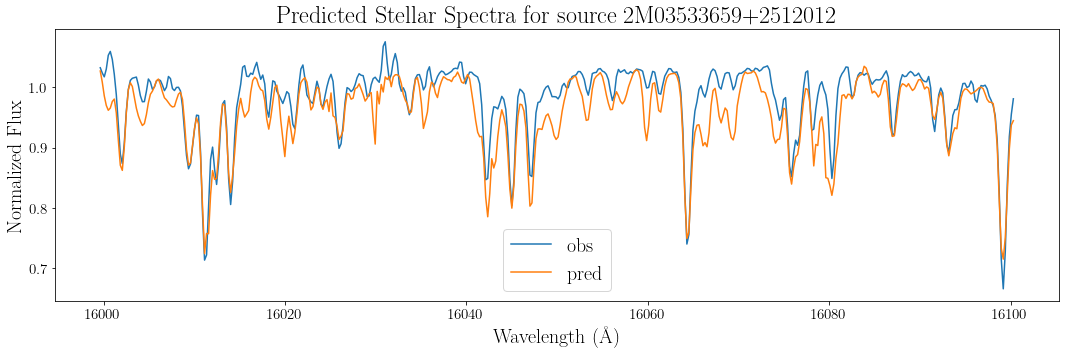

In [273]:
fig = plt.figure(figsize =(18, 5))
l, h = 4185, 4640
prediction =  predict_spectrum(allstar_star, X, l, h, True)
plt.plot(wavelength[l:h], speccer[l:h], label='obs')
plt.plot(wavelength[l:h], prediction, label='pred')
plt.title('Predicted Stellar Spectra for source 2M03533659+2512012')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Normalized Flux')
plt.legend(loc='lower center')

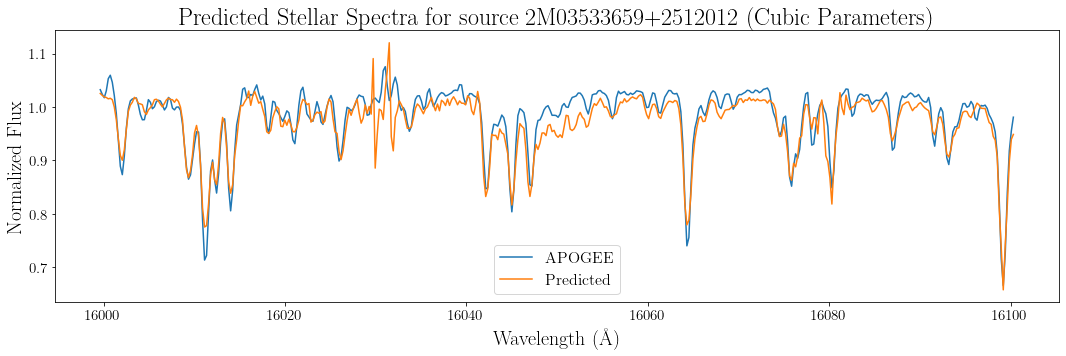

In [1000]:
fig = plt.figure(figsize =(18, 5))
l, h = 4185, 4640
prediction =  predict_spectrum(allstar_star, X, l, h, True)
plt.plot(wavelength[l:h], speccer[l:h], label='APOGEE')
plt.plot(wavelength[l:h], prediction, label='Predicted')
plt.title('Predicted Stellar Spectra for source 2M03533659+2512012 (Cubic Parameters)')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Normalized Flux')
plt.legend(loc='lower center', prop={'size':16})

In [ ]:
X.shape, A.shape, F.shape, W.shape

In [136]:
def predict_spectrum(star, X, low, high, is_star):
    #aX = F
    if is_star:
        a = build_a(star[0])
    else:
        a = build_a_w_labels(star)
    fluxes = []
    for i in range(low, high):
        fluxes.append(a @ X[i])
    return fluxes

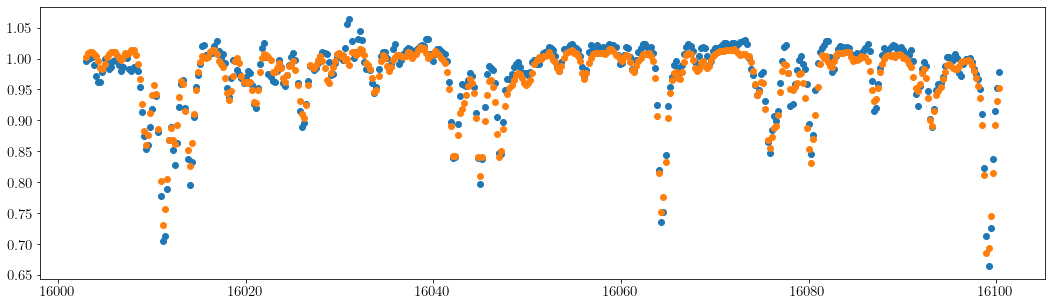

In [435]:
fig = plt.figure(figsize =(18, 5))
plt.scatter(wavelength[l:h], speccer[l:h], label='obs')
plt.scatter(wavelength[l:h], prediction, label='pred')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, '$\\partial f/\\partial T_{eff}$ ')

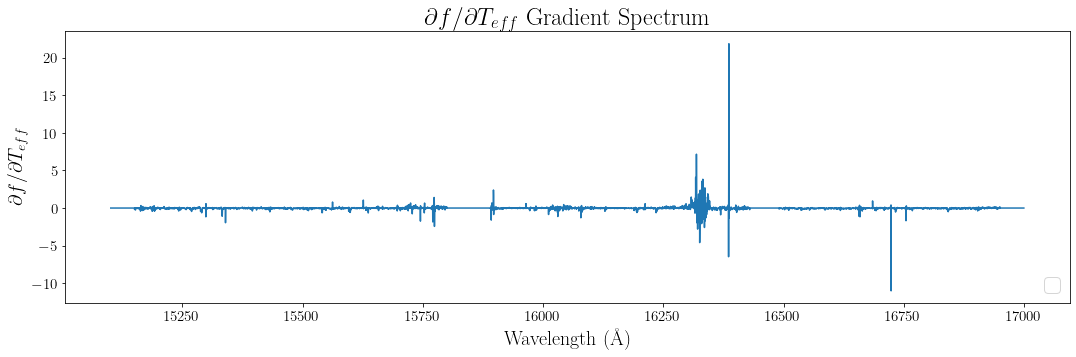

In [137]:
fig = plt.figure(figsize =(18, 5))
eps = .1/4682.93
pred1 =  predict_spectrum([1+eps, 1, 1, 1, 1], X, 0, 8575, False)
pred2 = predict_spectrum([1, 1, 1, 1, 1], X, 0, 8575, False)
diff = np.subtract(pred1, pred2)
diff = np.divide(diff, .1/4682.93)
plt.plot(wavelength, diff)
    
plt.title('$\partial f/\partial T_{eff}$ Gradient Spectrum')
plt.legend(loc='lower right')
plt.xlabel("Wavelength (\AA)")
plt.ylabel("$\partial f/\partial T_{eff}$ ")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, '$\\partial f/\\partial$log$g$ Gradient')

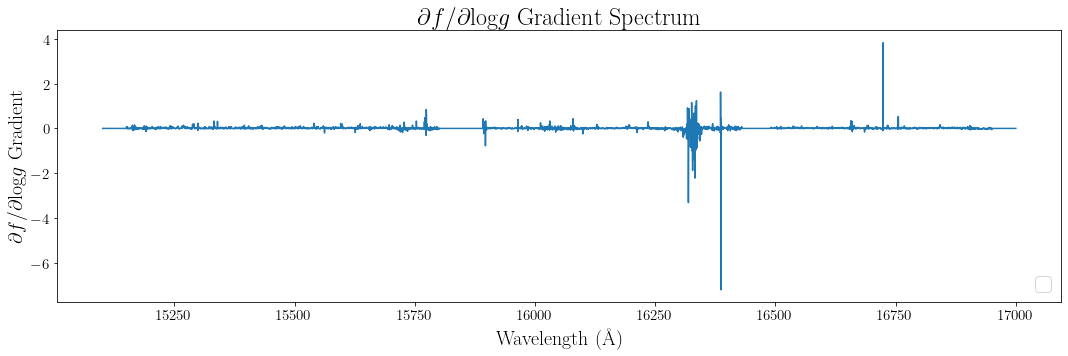

In [138]:
fig = plt.figure(figsize =(18, 5))
eps = 0.001/2.44
pred1 =  predict_spectrum([1, 1+eps, 1, 1, 1], X, 0, 8575, False)
pred2 = predict_spectrum([1, 1, 1, 1, 1], X, 0, 8575, False)
diff = np.subtract(pred1, pred2)
diff = np.divide(diff, 0.001/2.44)
plt.plot(wavelength, diff)
    
plt.title('$\partial f/\partial$log$g$ Gradient Spectrum')
plt.legend(loc='lower right')
plt.xlabel("Wavelength (\AA)")
plt.ylabel("$\partial f/\partial$log$g$ Gradient")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, '$\\partial f/\\partial$[Fe/H] Gradient')

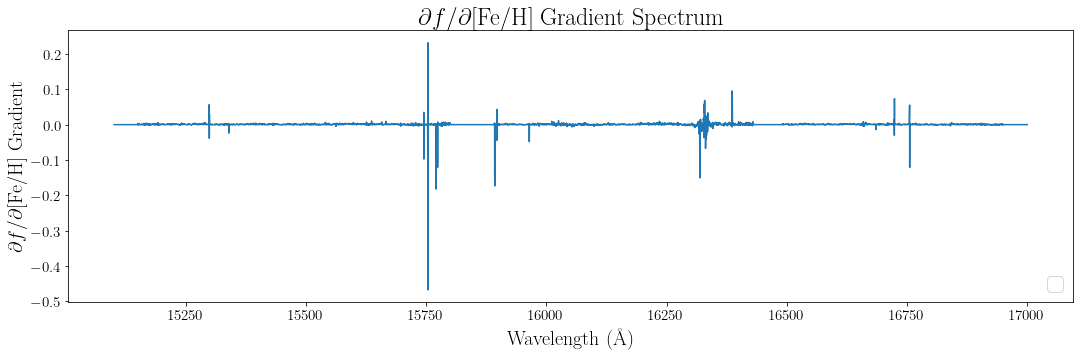

In [139]:
fig = plt.figure(figsize =(18, 5))
eps = 0.0001/-.07
pred1 =  predict_spectrum([1, 1, 1+eps, 1, 1], X, 0, 8575, False)
pred2 = predict_spectrum([1, 1, 1, 1, 1], X, 0, 8575, False)
diff = np.subtract(pred1, pred2)
diff = np.divide(diff, 0.0001/-.07)
plt.plot(wavelength, diff)
    
plt.title('$\partial f/\partial$[Fe/H] Gradient Spectrum')
plt.legend(loc='lower right')
plt.xlabel("Wavelength (\AA)")
plt.ylabel("$\partial f/\partial$[Fe/H] Gradient")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, '$\\partial f/\\partial$[Mg/Fe] Gradient')

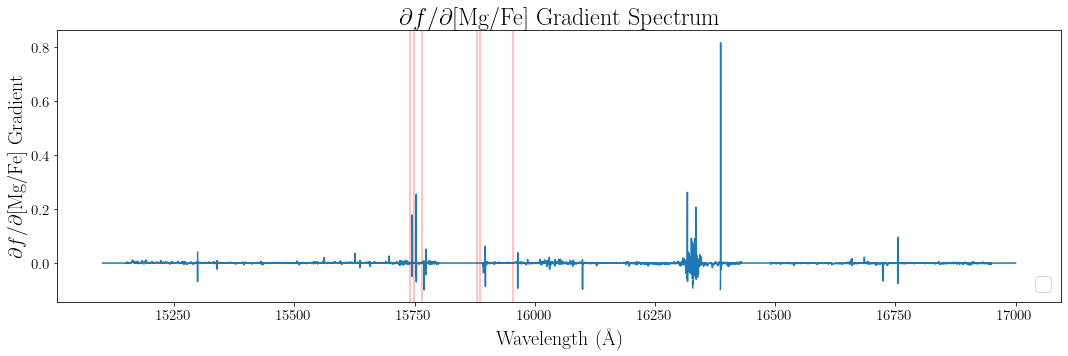

In [140]:
fig = plt.figure(figsize =(18, 5))
eps = 0.0001/.05
pred1 =  predict_spectrum([1, 1, 1, 1+eps, 1], X, 0, 8575, False)
pred2 = predict_spectrum([1, 1, 1, 1, 1], X, 0, 8575, False)
diff = np.subtract(pred1, pred2)
diff = np.divide(diff, 0.0001/.05)
diff[np.where(diff < -.1)] = np.nan
plt.plot(wavelength, diff)

plt.axvline(x=15740.716, color='r', linestyle='-', alpha=0.3)
plt.axvline(x=15748.9, color='r', linestyle='-', alpha=0.3)
plt.axvline(x=15765.8, color='r', linestyle='-', alpha=0.3)
plt.axvline(x=15879.5, color='r', linestyle='-', alpha=0.3)
plt.axvline(x=15954.477, color='r', linestyle='-', alpha=0.3)
plt.axvline(x=15886.2, color='r', linestyle='-', alpha=0.3)
plt.title('$\partial f/\partial$[Mg/Fe] Gradient Spectrum')
plt.legend(loc='lower right')
plt.xlabel("Wavelength (\AA)")
plt.ylabel("$\partial f/\partial$[Mg/Fe] Gradient")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, '$\\partial f/\\partial$[Si/Fe] Gradient')

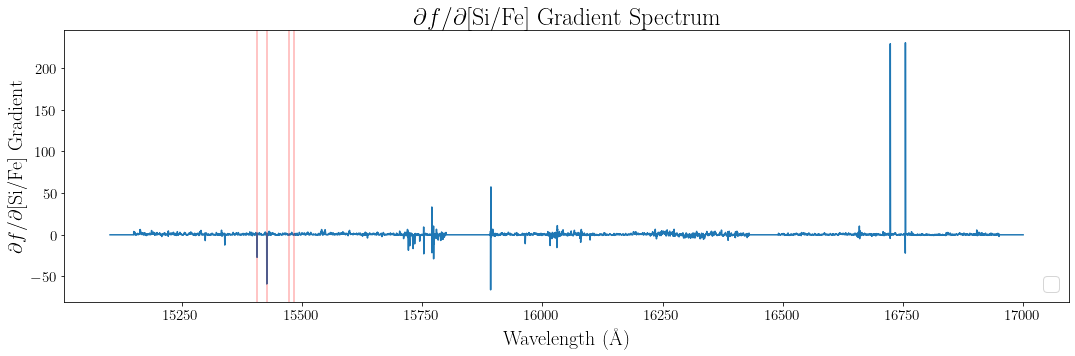

In [291]:
fig = plt.figure(figsize =(18, 5))
eps = 0.00001/.02
pred1 =  predict_spectrum([1, 1, 1, 1, 1+eps], X, 0, 8575, False)
pred2 = predict_spectrum([1, 1, 1, 1, 1], X, 0, 8575, False)
diff = np.subtract(pred1, pred2)
diff = np.divide(diff, 0.00001/.02)

idx = np.searchsorted(wavelength, 15406.540)
diff[idx] = -27

idx = np.searchsorted(wavelength, 15406.540)
diff[idx] = -27


idx = np.searchsorted(wavelength, 15426.490)+1
diff[idx] = -59

plt.plot(wavelength, diff)

plt.axvline(x=15406.540, color='r', linestyle='-', alpha=0.3)
plt.axvline(x=15482.712, color='r', linestyle='-', alpha=0.3)
plt.axvline(x=15474.043, color='r', linestyle='-', alpha=0.3)
plt.axvline(x=15426.490, color='r', linestyle='-', alpha=0.3)
    
plt.title('$\partial f/\partial$[Si/Fe] Gradient Spectrum')
plt.legend(loc='lower right')
plt.xlabel("Wavelength (\AA)")
plt.ylabel("$\partial f/\partial$[Si/Fe] Gradient")

In [143]:
def func(x, *args):
    #PREDICT THE PARAMS
    return x @ np.array(args)

In [274]:
import scipy
obs = []
pred = []
averages = {'TEFF': 4682.93, 'LOGG': 2.44, 'FE_H':-.07, 'MG_FE':.05, 'SI_FE':.02}
labels = ['TEFF', 'LOGG', 'FE_H', 'MG_FE', 'SI_FE']
for i in range(len(validation_all)):
    star = validation_all[i]
    print(i)
    o = [star['TEFF'], star['LOGG'], star['FE_H'], star['MG_FE'], star['SI_FE']]
    obs.append(o)
    spec, err = pseudo_normalize('./data/' + star['FIELD'] + '/' + star['FILE'])
    idxs = np.where(spec > 0.4)
    otra  = np.where(spec[idxs] < 1.1)
    
    popt, pcov = scipy.optimize.curve_fit(func, X[idxs][otra], spec[idxs][otra], p0=[1]*21)
    # first element should be 1 <- normalize to new basis
    # popt = np.divide(popt, popt[-1])
    i=0
    for label in labels:
        popt[i] *= averages[label]
        i+=1
    pred.append(popt[0:5])
    if o[0] > 5200:
        print(o[0], popt[0], popt[-1])

obs = np.array(obs)
pred = np.array(pred)

0
1


/var/folders/sv/rwqdq4111xd02y21sdbzrp5h0000gn/T/ipykernel_1296/34416567.py:64: RuntimeWarning: divide by zero encountered in double_scalars
  weights.append(min(100, 1/e))


2
3
5242.306 5909.885231508146 1.0010149626012754
4
5
6
7
8
9
10
11
12
13
14
5409.236 6302.998874387096 1.0060092081677712
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
5223.1973 6004.405016485606 1.0022791970156097
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
5320.252 6325.986880462866 1.0084156300025005
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
5394.6016 6535.780260212095 1.0065566848796808
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
5254.5117 6061.346185884065 1.0049085076689785
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
5438.5044 6995.789563365322 1.0102947246607745
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196


In [1130]:
print(min(pred[:, 0]), max(pred[:, 0]))
print(min(pred[:, 1]), max(pred[:, 1]))
print(min(pred[:, 2]), max(pred[:, 2]))
print(min(pred[:, 3]), max(pred[:, 3]))
print(min(pred[:, 4]), max(pred[:, 4]))

3707.7114538947144 5278.875637586019
0.7150335775587845 3.9484447276456947
-0.8224235821063466 0.48324259927985214
-0.15195110136116546 0.35676453003334446
-0.1534765322147457 0.32060422183772214


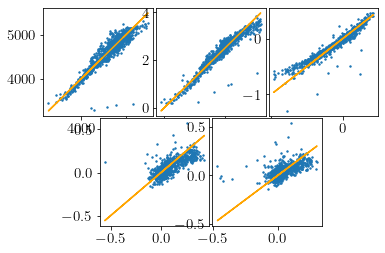

In [1011]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(36, 36)
gs.update(wspace=0.5, hspace=0.5)
ax1 = plt.subplot(gs[:18, :12])
ax2 = plt.subplot(gs[:18, 12:24])
ax3 = plt.subplot(gs[:18, 24:])
ax4 = plt.subplot(gs[18:, 6:18])
ax5 = plt.subplot(gs[18:, 18:30])

ax1.plot(obs[:, 0], obs[:, 0], c='orange')
ax1.scatter(obs[:, 0], pred[:, 0], s=2)

ax2.plot(obs[:, 1], obs[:, 1], c='orange')
ax2.scatter(obs[:, 1], pred[:, 1], s=2)

ax3.plot(obs[:, 2], obs[:, 2], c='orange')
ax3.scatter(obs[:, 2], pred[:, 2], s=2)

ax4.plot(obs[:, 3], obs[:, 3], c='orange')
ax4.scatter(obs[:, 3], pred[:, 3], s=2)

ax5.plot(obs[:, 4], obs[:, 4], c='orange')
ax5.scatter(obs[:, 4], pred[:, 4], s=2)

640.3894004410529


Text(0.5, 1.0, 'Predicted v APSCAP $T_{eff}$ (Cubic Parameters)')

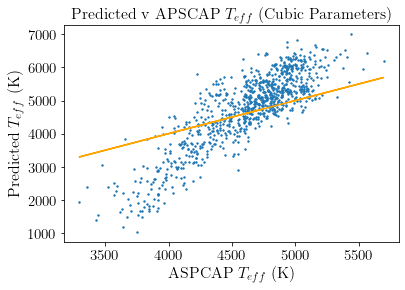

In [275]:
print(np.mean(np.abs(np.subtract(obs[:, 0], pred[:, 0]))))
plt.scatter(obs[:, 0], pred[:, 0], s=2)
plt.plot(obs[:, 0], obs[:, 0], c='orange')
plt.xlabel("ASPCAP $T_{eff}$ (K)", fontsize = 16)
plt.ylabel("Predicted $T_{eff}$ (K)", fontsize = 16)
plt.title('Predicted v APSCAP $T_{eff}$ (Cubic Parameters)', fontsize = 16)

Text(0.5, 1.0, 'Predicted v ASPCAP log$g$')

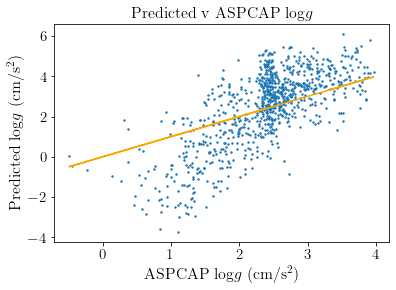

In [276]:
plt.scatter(obs[:, 1], pred[:, 1], s=2)
plt.plot(obs[:, 1], obs[:, 1], c='orange')
plt.xlabel("ASPCAP log$g$ (cm/s$^2$)", fontsize = 16)
plt.ylabel("Predicted log$g$ (cm/s$^2$)", fontsize = 16)
plt.title('Predicted v ASPCAP log$g$', fontsize = 16)

Text(0.5, 1.0, 'Predicted v ASPCAP [Fe/H]')

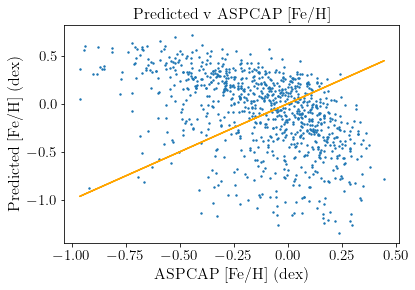

In [277]:
plt.scatter(obs[:, 2], pred[:,2], s=2)
plt.plot(obs[:, 2], obs[:, 2], c='orange')

plt.xlabel("ASPCAP [Fe/H] (dex)", fontsize = 16)
plt.ylabel("Predicted [Fe/H] (dex)", fontsize = 16)
plt.title('Predicted v ASPCAP [Fe/H]', fontsize = 16)

Text(0.5, 1.0, 'Predicted v ASPCAP [Mg/Fe]')

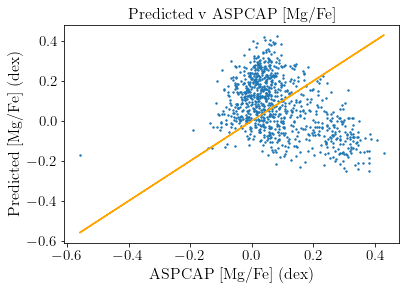

In [278]:
plt.scatter(obs[:, 3], pred[:,3], s=2)
plt.plot(obs[:, 3], obs[:, 3], c='orange')
plt.xlabel("ASPCAP [Mg/Fe] (dex)", fontsize = 16)
plt.ylabel("Predicted [Mg/Fe] (dex)", fontsize = 16)
plt.title('Predicted v ASPCAP [Mg/Fe]', fontsize = 16)

Text(0.5, 1.0, 'Predicted v ASPCAP [Si/Fe]')

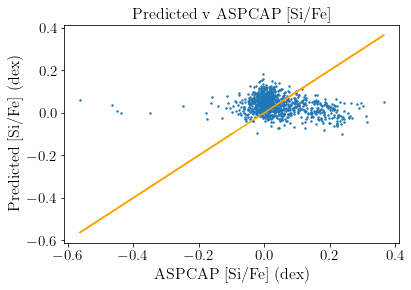

In [279]:
plt.scatter(obs[:, 4], pred[:,4], s=2)
plt.plot(obs[:, 4], obs[:, 4], c='orange')
plt.xlabel("ASPCAP [Si/Fe] (dex)", fontsize = 16)
plt.ylabel("Predicted [Si/Fe] (dex)", fontsize = 16)
plt.title('Predicted v ASPCAP [Si/Fe]', fontsize = 16)

In [181]:
metals = []
metals.append((np.loadtxt('/Users/abhishekkattuparambil/Desktop/astro_datalab/labs/lab2/data/solar.iso'), '[Fe/H] = 0'))
metals.append((np.loadtxt('/Users/abhishekkattuparambil/Desktop/astro_datalab/labs/lab2/data/neg.iso'), '[Fe/H] = -1'))


[0.52090561 1.00627984 1.5316239  2.01559998 2.50021627 3.02667936
 3.51470302] [ 5600.62854162  7398.1667491  10002.35717419 13213.14406971
 17454.59193094 23598.65304513 31173.51319827]


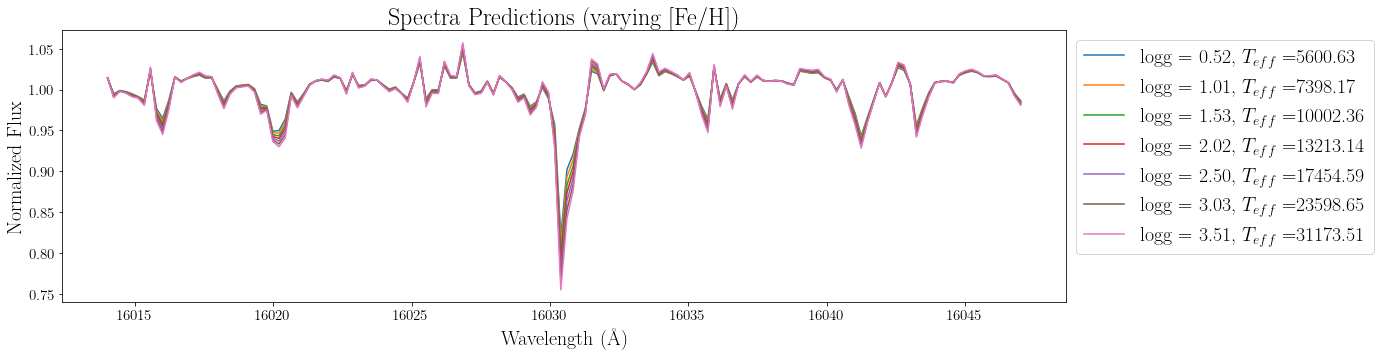

In [284]:
fig = plt.figure(figsize =(18, 5))
x = np.loadtxt('/Users/abhishekkattuparambil/Desktop/astro_datalab/labs/lab2/data/solar.iso')
idxs = np.hstack([np.searchsorted(x[:, 12], [0.5, 1, 1.5, 2, 2.5, 3, 3.5])])
loggs = x[:, 12][idxs]
temps = 10**x[:, 10][idxs]
for i in range(len(loggs)):
    l, h = 4250, 4400
    txt = "logg = {f:.2f}, "
    other = "{f:.2f}"
    f = loggs[i]/2.44
    x = temps[i]/4682.93
    prediction =  np.divide(predict_spectrum([x, f, 0, 0, 0], X, l, h, False), 100)+1
    plt.plot(wavelength[l:h], prediction, label=txt.format(f=f*2.44) + "$T_{eff} = $" + other.format(f=x*4682.93))
plt.title('Spectra Predictions (varying [Fe/H])')
plt.legend(loc='lower right')
plt.xlabel("Wavelength (\AA)")
plt.ylabel("Normalized Flux")
plt.gca().legend(prop={'size': 20}, bbox_to_anchor=(1, 1))
print(loggs, temps)

In [740]:
metals[0][0].shape

(1469, 25)

In [55]:
plt.figure(figsize=(10, 5))
begin = 223
end = 600
for (iso, label) in metals:
    print(iso[:, 12])
    temps = 10**iso[begin:end, 10]
    plt.plot(iso[begin:end, 12], temps, label=label, alpha=0.8)
    begin = 245
    end = 1185
plt.legend(loc='center right', prop={'size': 14})
plt.xlabel("log$(g)$")
plt.ylabel("$T_{eff}$")
plt.title('MIST Isochrone: Kiel Diagram')
cm = plt.cm.get_cmap('plasma')
sc = plt.scatter(pred[:, 1], pred[:, 0], s=15, alpha=0.8, c=pred[:, 2], vmin=-0.9, vmax=0.46, cmap=cm, zorder=-1)
plt.colorbar(sc)
plt.legend(loc='upper left')

NameError: name 'metals' is not defined

<Figure size 720x360 with 0 Axes>

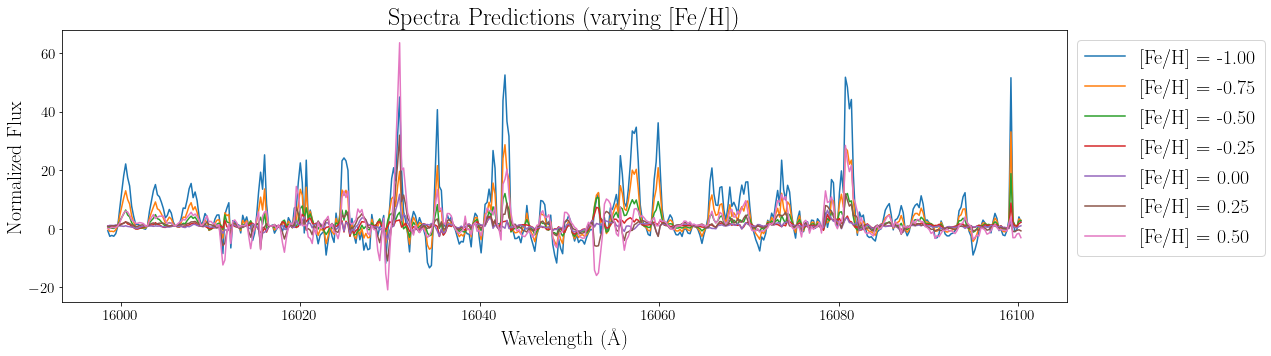

In [183]:
fig = plt.figure(figsize =(18, 5))
#l, h = 4200, 5100
l, h = 4180, 4640
txt = "[Fe/H] = {f:.2f}"
for f in np.arange(-1, 0.6, 0.25):
    f/=-.07
    prediction =  predict_spectrum([1, 1, f, 0, 0], X, l, h, False)
    plt.plot(wavelength[l:h], prediction, label=txt.format(f=f*-.07))
plt.title('Spectra Predictions (varying [Fe/H])')
plt.legend(loc='lower right')
plt.xlabel("Wavelength (\AA)")
plt.ylabel("Normalized Flux")
plt.gca().legend(prop={'size': 20}, bbox_to_anchor=(1, 1))

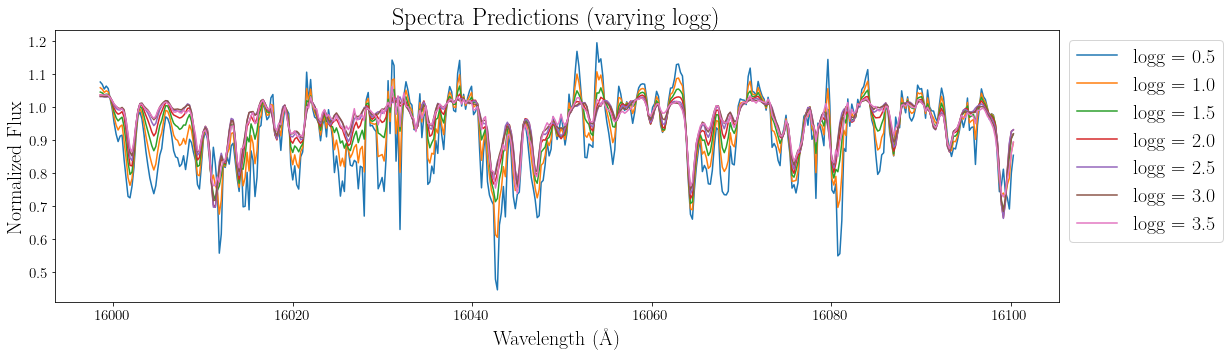

In [705]:
fig = plt.figure(figsize =(18, 5))
#l, h = 4200, 5100
l, h = 4180, 4640
txt = "logg = {f:.1f}"
for logg in np.arange(0.5, 3.6, 0.5):
    logg/=2.44
    prediction =  predict_spectrum([1, logg, 0, 0, 0], X, l, h, False)
    plt.plot(wavelength[l:h], prediction, label=txt.format(f=logg*2.44))
plt.title('Spectra Predictions (varying logg)')
plt.legend(loc='lower right')
plt.xlabel("Wavelength (\AA)")
plt.ylabel("Normalized Flux")
plt.gca().legend(prop={'size': 20}, bbox_to_anchor=(1, 1))

In [1012]:
# Open the sample APSTAR file
f = fits.open('./data/mystery_spec_wiped.fits')
spectrum = f[1].data
error = f[2].data
mask = f[3].data

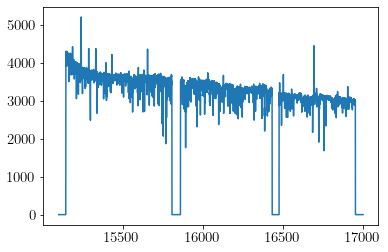

In [1020]:
# Plot a single spectrum
CRVAL = f[1].header['CRVAL1']
CRDELT1 = f[1].header['CDELT1'] 
wavelength = 10**np.arange(CRVAL, CRVAL + len(spectrum)*CRDELT1, CRDELT1)
plt.plot(wavelength, spectrum)

/var/folders/sv/rwqdq4111xd02y21sdbzrp5h0000gn/T/ipykernel_3377/4098893871.py:69: RuntimeWarning: divide by zero encountered in double_scalars
  weights.append(RARE*min(10000000, 1/e))
/Users/abhishekkattuparambil/opt/anaconda3/lib/python3.8/site-packages/pymc3/model.py:1755: ImputationWarning: Data in obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/abhishekkattuparambil/opt/anaconda3/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling 

/Users/abhishekkattuparambil/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 31 seconds.
INFO:pymc3:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 31 seconds.
There were 247 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 247 divergences after tuning. Increase `target_accept` or reparameterize.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 86 divergences after tuning. Increase `target_accept` or reparameterize.


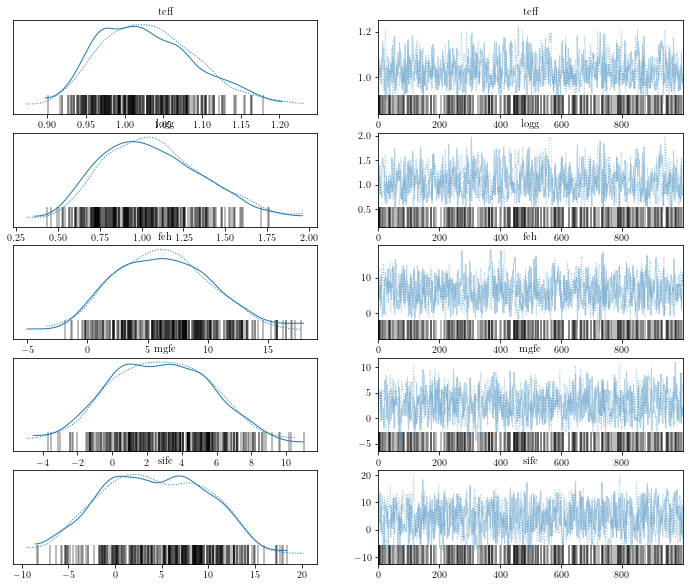

In [1165]:
import pymc3 as pm
spec, W = pseudo_normalize('./data/mystery_spec_wiped.fits', True, False)
spec[np.where(spec == -1)] = np.nan

with pm.Model() as model:
    #13, 1, scatter 3
    a = pm.Uniform("teff", lower=0.5, upper=1.5)
    b = pm.Uniform("logg", lower=0, upper=2)
    c = pm.Uniform("feh", lower=-10, upper=20)
    d = pm.Uniform("mgfe", lower=-5, upper=15)
    e = pm.Uniform("sife", lower=-10, upper=30) 
    #logsig = pm.Uniform("logsig", lower=-3, upper=-1)
    
    # define the log-likelihood function
    
    # note that numpy doesn't play nicely with PyMC, so you should use their built in math functions
    pm.Normal("obs", mu = pm.math.dot([a, b, c, d, e, a*a, a*b, a*c, a*d, a*e, b*b, b*c, b*d, b*e, c*c, c*d, c*e, d*d, d*e, e*e, 1], X.T), observed=spec)

    # now set up the model to run
    # default of PyMC is to use the no-turn sampler (NUTS)
    
    # pm.sample will run the sampler and store output in 'trace' 
    trace = pm.sample(draws=1000, tune=1000, chains=2, cores=2)
    
    # traceplot is a routine for plotting the 'traces' from the samples
    _ = pm.plot_trace(trace, var_names=["teff", "logg", "feh", "mgfe", "sife"])

    # pm.summary provides some useful summary and convergance statistics
    pm.summary(trace, var_names=["teff", "logg", "feh", "mgfe", "sife"])


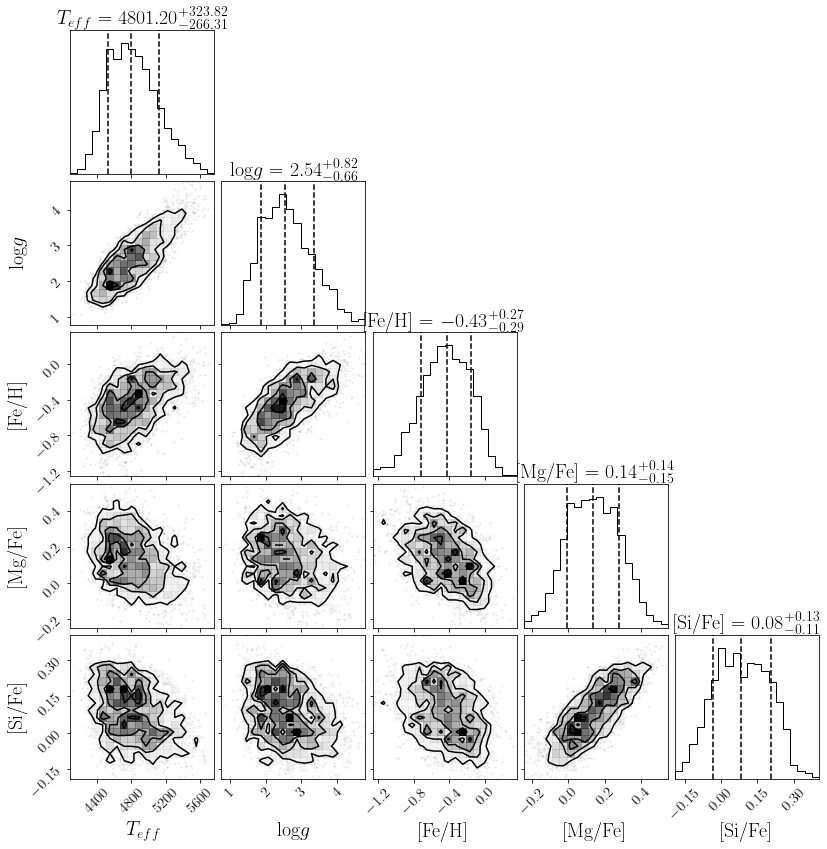

In [1166]:
import corner
import arviz as az
from arviz import plot_trace as traceplot
# translate trace into pandas dataframe for plotting (you can also plot numpy arrays with corner)
sams = pm.trace_to_dataframe(trace, varnames=["teff", "logg", "feh", "mgfe", "sife"])
averages = {'TEFF': 4682.93, 'LOGG': 2.44, 'FE_H':-.07, 'MG_FE':.05, 'SI_FE':.02}
labels = ['TEFF', 'LOGG', 'FE_H', 'MG_FE', 'SI_FE']
i=0
for r in sams:
    sams[r] = np.multiply(sams[r], averages[labels[i]])
    i+=1

# make the corner plot and plot results from Hubble's paper as 'truth'
# overplot percentiles: 16, 50, 84 on 1d historgrams
_ = corner.corner(sams, title_kwargs={"fontsize": 20}, show_titles = True, labels=[r"$T_{eff}$", r"log$g$", r"[Fe/H]", r"[Mg/Fe]", r"[Si/Fe]"], quantiles=[.16, .50, .84])
